In [1]:
%matplotlib notebook
import numpy as np
from numpy.fft import fft2, ifft2, fftshift
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
import scipy
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d as gf1d
from scipy.ndimage import gaussian_filter as gf
from scipy.ndimage import uniform_filter as uf
from skimage.transform import downscale_local_mean #For binning
from skimage.filters import threshold_otsu, threshold_local

import xarray as xr #package for labeling and adding metadata to multi-dimensional arrays

import sys
#sys.path.append("../kai_colloids/PyDDM") #must point to the PyDDM folder
#import ddm_analysis_and_fitting as ddm   

import tiff_file 

import io 
import sys
import csv

from PIL import Image

import os
import glob #glob is helpful for searching for filenames or directories
import pickle #for saving data
### usually this block prints out "nd2reader module not found. Reading of .nd2 files disabled." on the first run
### this is fine (unless you need to read .nd2 files), just re-run this block to make the error go away

C:\Users\gleech\Documents\GitHub\kai codes\best SIA\tiff_file.py:1995: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
C:\Users\gleech\Documents\GitHub\kai codes\best SIA\tiff_file.py:1995: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
C:\Users\gleech\Documents\GitHub\kai codes\best SIA\tiff_file.py:1995: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)


## First define the functions we will need to use
### The Structural Image Autocorrelation (SIA) function is the second function defined below

In [2]:
### this function (newRadav) finds the radial average of the image autocorrelation in the SIA function 
def newRadav(im, limangles=False, angRange=None, mask=None, rev=False,
             debug_q = None):
    if mask is None:
        hasMask = False
    else:
        hasMask = True
    nx,ny = im.shape
    xx = np.arange(-(nx-1)/2., nx/2.)
    yy = np.arange(-(ny-1)/2., ny/2.)
    #x,y = np.meshgrid(xx,yy)
    x,y = np.meshgrid(yy,xx)
    q = np.sqrt(x**2 + y**2)
    angles = np.arctan2(x,y)
    
    qx = np.arange(-1*nx/2,nx/2)*(1./nx) * max(nx,ny)
    qy = np.arange(-1*ny/2,ny/2)*(1./ny) * max(nx,ny)
    qxx,qyy = np.meshgrid(qy,qx) #qy,qx is correct order
    q_new = np.sqrt(qxx**2 + qyy**2)
    
    if debug_q is not None:
        return q_new.round().astype(int)==debug_q
    
    if mask is None:
        mask = np.ones_like(angles)
    if angRange is not None:
        w1 = np.where(angles>angRange[0])
    else:
        w1 = np.where(angles>(13*np.pi/14))
    if mask is None:
        mask[w1]=0
        mask = mask * np.rot90(np.rot90(mask))
        mask = mask * np.flipud(mask)
        mask[np.where(mask==0)] = np.nan
        if rev:
            mask = np.rot90(mask)
    qr = q_new.round().astype(int)
    #rs = np.arange(0,(nx-1)/2)
    rs = np.arange(0,(max(nx,ny)-1)/2) 
    radav = np.zeros((len(rs)),dtype=float)
    for i in range(0,len(rs)):
        w = np.where(qr==rs[i])
        if len(w[0])>0:
            if limangles or hasMask:
                newim = im*mask
                radav[i] = np.nanmean(newim[w])
            else:
                radav[i] = np.nanmean(im[w])
        #else:
        #    print i
    return radav

def zerolistmaker(n):
    listofzeros = ['none found'] * n
    return listofzeros

def threshold_images(image, block_size, offset_val):
    ed_image = (image**0.2)*500
    ed_thresh = threshold_local(ed_image, block_size, offset= offset_val)
    ed_binary_im = 1*(ed_image > ed_thresh)
    #binned_ed_binary_im = downscale_local_mean(ed_binary_im, (2,2), cval=1)
    #print(binned_ed_binary_im.shape)
    #return binned_ed_binary_im
    return ed_binary_im

### the SIA function 
def SIA(image, block_size, offset_val):
    ''' Computes image autocorrelation. 
    Takes as input:
        image: 2D image
        filter: Boolean, if true will filter image with uniform filter
        filtersize: size for uniform filtering
    Returns:
        corr_im: the image autocorrelation (this will be same size as image)
        rav_corr: radially averaged image autocorrelation '''
    
    ### Crop image
    #image = image[:1440, :1440]    ###option to crop out any large noise features 

    image = threshold_images(image, block_size, offset_val)
    
    image = 1.0*image-image.mean() #subtract mean
    image = image/image.std() #normalize by standard deviation
    corr_im = np.real(fftshift(ifft2(fft2(image)*np.conj(fft2(image)))))/(image.shape[0]*image.shape[1])
    
    ### radial average taken
    rav_corr = newRadav(corr_im)
    
    ### return ONLY rav_corr **b/c I don't need corr_im** (change this if you do need corr_im) 
    return rav_corr

###define the single exponential we use to fit SIA curves
str_equation = False
def single_exponential(x, A, cl):
    #return (np.exp(-x/cl) + A) 
    if str_equation == True:
        return "(1-A)*exp(-x/cl) + A"
    else:
        return (1-A)*(np.exp(-x/cl)) + A
    
### the following functions ('show_threshold_images', and 'show_filtered_images') are used to preview 
### the images intended for analysis
def show_raw_images(row, ax, i, frame_key):
    plt.gray()
    index_add = arr_length * (row -1)
    if time_array[i] == 0:
        test_image = np.zeros((1440,1920))
        ax.set_title('[no image]', fontsize=10)
    else:
        test_image = tiff_file.imread(files[i+index_add],key=[frame_key])
        ax.set_title("~" + str(time_array[i]) + " hrs (row"+str(row)+")", fontsize=10)
    ax.imshow(test_image) #cmap = 'gray'
    ax.axis('off')
    plt.tight_layout(pad=.2)
    
def show_threshold_images(row, ax, i, frame_key, block_size, offset_val):
    index_add = arr_length * (row -1)
    if time_array[i] == 0:
        threshold_image = np.zeros((1440,1920))
        ax.set_title('[no image]', fontsize=10)
    else:
        raw_image = tiff_file.imread(files[i+index_add],key=[frame_key])
        ax.set_title("~" + str(time_array[i]) + " hrs (row"+str(row)+") --> threshold", fontsize=10)
        threshold_image = threshold_images(raw_image, block_size, offset_val)
    ax.imshow(threshold_image, cmap = 'gray')
    ax.axis('off')
    plt.tight_layout(pad=.2)



## Locate your data (tiff files) and choose where to save results     

In [3]:
directory = "Z"
exp = "7-18-22_bkaiB_ratios"
### "data_dir" is the pathway to the folder holding the tiff files to be analyzed 
data_dir = directory+":\\Gregor L\\__Kai Colloids\\control exps\\"+exp+"\\all tiffs\\" 
#data_dir2 = directory+":\\Gregor L\\__Kai Colloids\\"+exp+"\\SIA preview images\\" #bottom_row_t01\\

### "plot_saveto" is the pathway to the folder where plots and results will be saved
data_saveto= directory+":\\Gregor L\\__Kai Colloids\\control exps\\"+exp+"\\" 

all_files = glob.glob(data_dir+"*_t*") ### this should generate an ordered list of files in "data_dir" which have "_t" in their name
print("found %i files" % len(all_files))
for i,f in enumerate(all_files): print (' %i \t %s' % (i, f.split('\\')[-1]))

found 30 files
 0 	 row1_t01_MMStack_Pos0.ome.tif
 1 	 row1_t02_MMStack_Pos0.ome.tif
 2 	 row1_t03_MMStack_Pos0.ome.tif
 3 	 row1_t04_MMStack_Pos0.ome.tif
 4 	 row1_t05_MMStack_Pos0.ome.tif
 5 	 row1_t06_MMStack_Pos0.ome.tif
 6 	 row1_t07_MMStack_Pos0.ome.tif
 7 	 row1_t08_MMStack_Pos0.ome.tif
 8 	 row1_t09_MMStack_Pos0.ome.tif
 9 	 row1_t10_MMStack_Pos0.ome.tif
 10 	 row2_t01_MMStack_Pos0.ome.tif
 11 	 row2_t02_MMStack_Pos0.ome.tif
 12 	 row2_t03_MMStack_Pos0.ome.tif
 13 	 row2_t04_MMStack_Pos0.ome.tif
 14 	 row2_t05_MMStack_Pos0.ome.tif
 15 	 row2_t06_MMStack_Pos0.ome.tif
 16 	 row2_t07_MMStack_Pos0.ome.tif
 17 	 row2_t08_MMStack_Pos0.ome.tif
 18 	 row2_t09_MMStack_Pos0.ome.tif
 19 	 row2_t10_MMStack_Pos0.ome.tif
 20 	 row3_t01_MMStack_Pos0.ome.tif
 21 	 row3_t02_MMStack_Pos0.ome.tif
 22 	 row3_t03_MMStack_Pos0.ome.tif
 23 	 row3_t04_MMStack_Pos0.ome.tif
 24 	 row3_t05_MMStack_Pos0.ome.tif
 25 	 row3_t06_MMStack_Pos0.ome.tif
 26 	 row3_t07_MMStack_Pos0.ome.tif
 27 	 row3_t08_MMStack_

## Specify pixel size, each condition (frame_names), and the time points of data collection (time_array)

In [5]:
frame_names = ["50% bKaiB", "35% bKaiB", "20% bKaiB", "pT (20% bKaiB)"]
### array containing the name for each frame in a tiff file to be run 
### e.g. frame 1 is an image of the "50% bKaiB" condition, frame 2 is an image of the "35% bKaiB" condition, etc.

time_array = [1, 4, 7, 9, 12, 15, 18, 21, 25, 28]
total_rows = 3
#s1 [0.7, 3.7, 6.7, 10.0, 12.8, 17.7, 21.7, 24.9, 28.2]
#s2 [1.0, 3.8, 6.8, 10.2, 13.1, 18.0, 21.9, 25.3, 28.7]
### array containing the time points corresponding to consecutive tiff files
### e.g. tiff files "bottom_row_t1", "middle_row_t1", and "top_row_t1" all correspond to t = 0.5 hrs, time_array[0]

#pixel_size = 0.364 # 4*0.091 = 0.364
pixels_per_bead = 11
### pixel size (microns per pixel) of frames/ images in the tiff files --- 40x olympus objective => 0.091 um/px
### IF 2x2 BINNING: multiply the original pixel size by 2^2 = 4, e.g. 4*(0.091 um/px) = 0.364 um/px

eg_im= tiff_file.imread(all_files[0])
print("tiff file dimensions: "+ str(eg_im.shape))

num_times = 10
print("total number of time points: "+ str(num_times))
if num_times % 2 == 0:
    num_rows = int(num_times/2)
else:
    num_rows = int((num_times+1)/2)
print("(for image previews) number of rows = " + str(num_rows))

tiff file dimensions: (4, 1440, 1920)
total number of time points: 10
(for image previews) number of rows = 5


## Choose size, font, and quality level (dpi_num) for the plots to be made

In [24]:
fig_size = 7,6
###  size of output figures
font_size = 20
### font size
dpi_num = 600
### image quality level (recommendation: 600)
svg_saveto =  directory+":\\Gregor L\\__Kai Colloids\\control exps\\"+exp+"\\" 
data_saveto= directory+":\\Gregor L\\__Kai Colloids\\control exps\\"+exp+"\\" 

# For better results, we filter & 'skeletonize' the images before analysis 
### Do we need to filter out background noise from the images? If so, we can try out different filter sizes to see which works best. The following block previews the images intended for SIA analysis, showing the filtered and skeletonized images
'skeletonize' means we find a specific threshold (based on median intensity), so all pixel values above that threshold = 1, and all pixel values below that threshold = 0. This gives structures clean borders for improved correlation analysis, g(r).

In [8]:
all_avg_gr = np.zeros((4, num_times, 960))
all_gr_stdE = np.zeros((4, num_times, 960))

all_avg_fits = np.zeros((4, num_times, 1000))
all_fits_stdE = np.zeros((4, num_times, 1000))

all_avg_A = np.zeros((4, num_times))
all_A_stdE =np.zeros((4, num_times))

all_avg_cl = np.zeros((4, num_times))
all_cl_stdE =np.zeros((4, num_times))

all_avg_gr.shape

(4, 10, 960)

In [9]:
def select_cmap(frame_key):
    if frame_key == 0:
        print("50% bKaiB")
        return 'o', 'm', matplotlib.cm.get_cmap('RdPu'), "50% bKaiB" 
    elif frame_key == 1:
        print("35% bKaiB")
        return '<', 'hotpink', matplotlib.cm.get_cmap('Greens'), "35% bKaiB"
    elif frame_key == 2:
        print("20% bKaiB")
        return '>', 'pink', matplotlib.cm.get_cmap('Blues'), "20% bKaiB"
    elif frame_key == 3:
        print("pT (20% bKaiB)")
        return 's', 'k', matplotlib.cm.get_cmap('gist_yarg'),  "pT (20% bKaiB)"  
    
def select_data_arrays(t_num):
    if t_num == 1:
        print("selected arrays for t_num= "+str(t_num)+", "+str(time_array[t_num -1])+" hrs")
        return t1_gr_curve, t1_gr_fits, t1_A_vals, t1_cl_vals
    if t_num == 2:
        print("selected arrays for t_num= "+str(t_num)+", "+str(time_array[t_num -1])+" hrs")
        return t2_gr_curve, t2_gr_fits, t2_A_vals, t2_cl_vals
    if t_num == 3:
        print("selected arrays for t_num= "+str(t_num)+", "+str(time_array[t_num -1])+" hrs")
        return t3_gr_curve, t3_gr_fits, t3_A_vals, t3_cl_vals
    if t_num == 4:
        print("selected arrays for t_num= "+str(t_num)+", "+str(time_array[t_num -1])+" hrs")
        return t4_gr_curve, t4_gr_fits, t4_A_vals, t4_cl_vals
    if t_num == 5:
        print("selected arrays for t_num= "+str(t_num)+", "+str(time_array[t_num -1])+" hrs")
        return t5_gr_curve, t5_gr_fits, t5_A_vals, t5_cl_vals
    if t_num == 6:
        print("selected arrays for t_num= "+str(t_num)+", "+str(time_array[t_num -1])+" hrs")
        return t6_gr_curve, t6_gr_fits, t6_A_vals, t6_cl_vals
    if t_num == 7:
        print("selected arrays for t_num= "+str(t_num)+", "+str(time_array[t_num -1])+" hrs")
        return t7_gr_curve, t7_gr_fits, t7_A_vals, t7_cl_vals
    if t_num == 8:
        print("selected arrays for t_num= "+str(t_num)+", "+str(time_array[t_num -1])+" hrs")
        return t8_gr_curve, t8_gr_fits, t8_A_vals, t8_cl_vals
    if t_num == 9:
        print("selected arrays for t_num= "+str(t_num)+", "+str(time_array[t_num -1])+" hrs")
        return t9_gr_curve, t9_gr_fits, t9_A_vals, t9_cl_vals
    if t_num == 10:
        print("selected arrays for t_num= "+str(t_num)+", "+str(time_array[t_num -1])+" hrs")
        return t9_gr_curve, t9_gr_fits, t9_A_vals, t9_cl_vals

    
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 2.2 #set the value globally
mpl.rcParams['mathtext.default'] = 'regular'

In [10]:
def select_results(frame_key):
    if frame_key == 0:
        print("50% bKaiB")
        #matplotlib.cm.get_cmap('Reds')
        return bKaiB50_all_t_A_vals, bKaiB50_all_t_cl_vals, "50% bKaiB" 
    elif frame_key == 1:
        print("35% bKaiB")
        return bKaiB35_all_t_A_vals, bKaiB35_all_t_cl_vals, "35% bKaiB" 
    elif frame_key == 2:
        print("20% bKaiB")
        return bKaiB20_all_t_A_vals, bKaiB20_all_t_cl_vals, "20% bKaiB" 
    elif frame_key == 3:
        print("pT (20% bKaiB)")
        return AE_all_t_A_vals, AE_all_t_cl_vals, "pT (20% bKaiB)" 

In [14]:
t1_gr_curve = np.zeros((3,960))
t2_gr_curve = np.zeros((3,960))
t3_gr_curve = np.zeros((3,960))
t4_gr_curve = np.zeros((3,960))
t5_gr_curve = np.zeros((3,960))
t6_gr_curve = np.zeros((3,960))
t7_gr_curve = np.zeros((3,960))
t8_gr_curve = np.zeros((3,960))
t9_gr_curve = np.zeros((3,960))
t10_gr_curve = np.zeros((3,960))

t1_gr_fits = np.zeros((3,1000))
t2_gr_fits = np.zeros((3,1000))
t3_gr_fits = np.zeros((3,1000))
t4_gr_fits = np.zeros((3,1000))
t5_gr_fits = np.zeros((3,1000))
t6_gr_fits = np.zeros((3,1000))
t7_gr_fits = np.zeros((3,1000))
t8_gr_fits = np.zeros((3,1000))
t9_gr_fits = np.zeros((3,1000))
t10_gr_fits = np.zeros((3,1000))

t1_A_vals = np.zeros((3,1))
t2_A_vals = np.zeros((3,1))
t3_A_vals = np.zeros((3,1))
t4_A_vals = np.zeros((3,1))
t5_A_vals = np.zeros((3,1))
t6_A_vals = np.zeros((3,1))
t7_A_vals = np.zeros((3,1))
t8_A_vals = np.zeros((3,1))
t9_A_vals = np.zeros((3,1))
t10_A_vals = np.zeros((3,1))

t1_cl_vals = np.zeros((3,1))
t2_cl_vals = np.zeros((3,1))
t3_cl_vals = np.zeros((3,1))
t4_cl_vals = np.zeros((3,1))
t5_cl_vals = np.zeros((3,1))
t6_cl_vals = np.zeros((3,1))
t7_cl_vals = np.zeros((3,1))
t8_cl_vals = np.zeros((3,1))
t9_cl_vals = np.zeros((3,1))
t10_cl_vals = np.zeros((3,1))


row_to_write = [''] * 11 * 5

In [14]:
fk = 3
condition = frame_names[fk]

ims_each_time = 18

block_size = 1051
offset_val = -20

fit_start = 0
fit_lim = -1 

all_xvalues = np.arange(960)/ pixels_per_bead
x_fit_values = np.linspace(all_xvalues[fit_start], all_xvalues[fit_lim], 1000)

## Now we can run some SIA! 

In [20]:
fk = 3
condition = frame_names[fk]

ims_each_time = 3

block_size = 1051
offset_val = -20

fit_start = 0
fit_lim = -1 

all_xvalues = np.arange(960)/ pixels_per_bead
x_fit_values = np.linspace(all_xvalues[fit_start], all_xvalues[fit_lim], 1000)
for i in range(num_times):
    time = str(time_array[i])
    print("condition: "+condition + "\t time: "+time+" hrs")
    t_num = 1 + i
    gr_curves, gr_fits, A_vals, cl_vals = select_data_arrays(t_num)
    one_time_all = []
    for j in range(len(all_files)): 
        #print(str(all_files[i].split('\\')[-1][5:-21]))
        t = str(all_files[j].split('\\')[-1][5:-21])
        if t == ('t0'+str(t_num)) or t == ('t'+str(t_num)):
            print(all_files[j].split('\\')[-1][5:-21])
            one_time_all.append(all_files[j])
            
    for g in range(ims_each_time):
        gr_curves[g] = SIA(tiff_file.imread(one_time_all[g],key=[fk]),block_size, offset_val)
    
    all_avg_gr[fk,i] = gr_curves.mean(axis=0)
    all_gr_stdE[fk,i] = (gr_curves.std(axis=0))/np.sqrt(ims_each_time)
    
    for f in range(ims_each_time):
        y_array = gr_curves[f]
        popt, pcov = curve_fit(single_exponential, all_xvalues[fit_start:fit_lim], y_array[fit_start:fit_lim])
        A, cl = tuple(popt)
        gr_fits[f] = single_exponential(x_fit_values, *popt)
        A_vals[f] = A
        cl_vals[f] = cl
        
    all_avg_fits[fk,i] = gr_fits.mean(axis=0)
    all_fits_stdE[fk,i] = (gr_fits.std(axis=0))/np.sqrt(ims_each_time)

    all_avg_A[fk,i] = A_vals.mean(axis=0)
    all_A_stdE[fk,i] = (A_vals.std(axis=0))/np.sqrt(ims_each_time)

    all_avg_cl[fk,i] = cl_vals.mean(axis=0)
    all_cl_stdE[fk,i] = (cl_vals.std(axis=0))/np.sqrt(ims_each_time)
    
if fk == 0:
    bKaiB50_all_t_A_vals=[t1_A_vals, t2_A_vals, t3_A_vals, t4_A_vals,
                       t5_A_vals, t6_A_vals, t7_A_vals, t8_A_vals, t9_A_vals]
    bKaiB50_all_t_cl_vals=[t1_cl_vals, t2_cl_vals, t3_cl_vals, t4_cl_vals,
                       t5_cl_vals, t6_cl_vals, t7_cl_vals, t8_cl_vals, t9_cl_vals]
if fk == 1:
    bKaiB35_all_t_A_vals=[t1_A_vals, t2_A_vals, t3_A_vals, t4_A_vals,
                         t5_A_vals, t6_A_vals, t7_A_vals, t8_A_vals, t9_A_vals]
    bKaiB35_all_t_=[t1_cl_vals, t2_cl_vals, t3_cl_vals, t4_cl_vals,
                          t5_cl_vals, t6_cl_vals, t7_cl_vals, t8_cl_vals, t9_cl_vals]
if fk == 2:
    bKaiB20_all_t_A_vals=[t1_A_vals, t2_A_vals, t3_A_vals, t4_A_vals,
                     t5_A_vals, t6_A_vals, t7_A_vals, t8_A_vals, t9_A_vals]
    bKaiB20_all_t_cl_vals=[t1_cl_vals, t2_cl_vals, t3_cl_vals, t4_cl_vals,
                      t5_cl_vals, t6_cl_vals, t7_cl_vals, t8_cl_vals, t9_cl_vals] 
if fk == 3:
    AE_all_t_A_vals=[t1_A_vals, t2_A_vals, t3_A_vals, t4_A_vals,
                     t5_A_vals, t6_A_vals, t7_A_vals, t8_A_vals, t9_A_vals]
    AE_all_t_cl_vals=[t1_cl_vals, t2_cl_vals, t3_cl_vals, t4_cl_vals,
                      t5_cl_vals, t6_cl_vals, t7_cl_vals, t8_cl_vals, t9_cl_vals]

condition: pT (20% bKaiB)	 time: 1 hrs
selected arrays for t_num= 1, 1 hrs
t01
t01
t01
condition: pT (20% bKaiB)	 time: 4 hrs
selected arrays for t_num= 2, 4 hrs
t02
t02
t02
condition: pT (20% bKaiB)	 time: 7 hrs
selected arrays for t_num= 3, 7 hrs
t03
t03
t03
condition: pT (20% bKaiB)	 time: 9 hrs
selected arrays for t_num= 4, 9 hrs
t04
t04
t04
condition: pT (20% bKaiB)	 time: 12 hrs
selected arrays for t_num= 5, 12 hrs
t05
t05
t05
condition: pT (20% bKaiB)	 time: 15 hrs
selected arrays for t_num= 6, 15 hrs
t06
t06
t06
condition: pT (20% bKaiB)	 time: 18 hrs
selected arrays for t_num= 7, 18 hrs
t07
t07
t07
condition: pT (20% bKaiB)	 time: 21 hrs
selected arrays for t_num= 8, 21 hrs
t08
t08
t08
condition: pT (20% bKaiB)	 time: 25 hrs
selected arrays for t_num= 9, 25 hrs
t09
t09
t09
condition: pT (20% bKaiB)	 time: 28 hrs
selected arrays for t_num= 10, 28 hrs
t10
t10
t10


In [51]:
#print(len(WTkA_all_t_cl_vals[0]))
#print(EA_all_t_cl_vals[0])
#print(AE_all_t_cl_vals[0])
from statistics import median
from statistics import mode
from statistics import mean

18


In [46]:
all_median_cl = np.zeros((4, num_times))

In [58]:
fk = 2
all_t_A_vals, all_t_cl_vals, data_label = select_results(fk)
for t in range(9):
    all_median_cl[fk][t] = median((all_t_cl_vals[t] *1))
print("median correlation lengths:")
print(all_median_cl[fk]*2)

EA
median correlation lengths
[2.58171292 2.94008135 2.97383484 3.10120474 3.83135714 3.77122776
 3.74306051 3.92355098 4.15568361]


In [76]:
fk = 3
all_t_A_vals, all_t_cl_vals, data_label = select_results(fk)
for t in range(9):
    all_median_cl[fk][t] = np.mean((all_t_cl_vals[t] *2))
print("mean correlation lengths:")
print("    %1.2f, %1.2f, %1.2f, %1.2f, %1.2f, %1.2f, %1.2f, %1.2f, %1.2f" %(all_median_cl[fk][0],all_median_cl[fk][1],
                                                                        all_median_cl[fk][2],all_median_cl[fk][3],
                                                                        all_median_cl[fk][4],all_median_cl[fk][5],
                                                                        all_median_cl[fk][6],all_median_cl[fk][7],
                                                                        all_median_cl[fk][8]))
for t in range(9):
    all_median_cl[fk][t] = median((all_t_cl_vals[t] *2))
print("median correlation lengths:")
print("    %1.2f, %1.2f, %1.2f, %1.2f, %1.2f, %1.2f, %1.2f, %1.2f, %1.2f" %(all_median_cl[fk][0],all_median_cl[fk][1],
                                                                        all_median_cl[fk][2],all_median_cl[fk][3],
                                                                        all_median_cl[fk][4],all_median_cl[fk][5],
                                                                        all_median_cl[fk][6],all_median_cl[fk][7],
                                                                        all_median_cl[fk][8]))
print(" ")

fk = 2
all_t_A_vals, all_t_cl_vals, data_label = select_results(fk)
for t in range(9):
    all_median_cl[fk][t] = np.mean((all_t_cl_vals[t] *2))
print("mean correlation lengths:")
print("    %1.2f, %1.2f, %1.2f, %1.2f, %1.2f, %1.2f, %1.2f, %1.2f, %1.2f" %(all_median_cl[fk][0],all_median_cl[fk][1],
                                                                        all_median_cl[fk][2],all_median_cl[fk][3],
                                                                        all_median_cl[fk][4],all_median_cl[fk][5],
                                                                        all_median_cl[fk][6],all_median_cl[fk][7],
                                                                        all_median_cl[fk][8]))
for t in range(9):
    all_median_cl[fk][t] = median((all_t_cl_vals[t] *2))
print("median correlation lengths:")
print("    %1.2f, %1.2f, %1.2f, %1.2f, %1.2f, %1.2f, %1.2f, %1.2f, %1.2f" %(all_median_cl[fk][0],all_median_cl[fk][1],
                                                                        all_median_cl[fk][2],all_median_cl[fk][3],
                                                                        all_median_cl[fk][4],all_median_cl[fk][5],
                                                                        all_median_cl[fk][6],all_median_cl[fk][7],
                                                                        all_median_cl[fk][8]))
print(" ")

fk = 0
all_t_A_vals, all_t_cl_vals, data_label = select_results(fk)
for t in range(9):
    all_median_cl[fk][t] = np.mean((all_t_cl_vals[t] *2))
print("mean correlation lengths:")
print("    %1.2f, %1.2f, %1.2f, %1.2f, %1.2f, %1.2f, %1.2f, %1.2f, %1.2f" %(all_median_cl[fk][0],all_median_cl[fk][1],
                                                                        all_median_cl[fk][2],all_median_cl[fk][3],
                                                                        all_median_cl[fk][4],all_median_cl[fk][5],
                                                                        all_median_cl[fk][6],all_median_cl[fk][7],
                                                                        all_median_cl[fk][8]))
for t in range(9):
    all_median_cl[fk][t] = median((all_t_cl_vals[t] *2))
print("median correlation lengths:")
print("    %1.2f, %1.2f, %1.2f, %1.2f, %1.2f, %1.2f, %1.2f, %1.2f, %1.2f" %(all_median_cl[fk][0],all_median_cl[fk][1],
                                                                        all_median_cl[fk][2],all_median_cl[fk][3],
                                                                        all_median_cl[fk][4],all_median_cl[fk][5],
                                                                        all_median_cl[fk][6],all_median_cl[fk][7],
                                                                        all_median_cl[fk][8]))
print(" ")

AE
mean correlation lengths:
    1.66, 1.75, 1.75, 1.83, 1.82, 1.85, 1.83, 1.85, 1.88
median correlation lengths:
    1.51, 1.61, 1.66, 1.81, 1.78, 1.81, 1.79, 1.80, 1.82
 
EA
mean correlation lengths:
    2.65, 2.95, 3.09, 3.26, 4.01, 3.81, 3.81, 4.04, 4.62
median correlation lengths:
    2.58, 2.94, 2.97, 3.10, 3.83, 3.77, 3.74, 3.92, 4.16
 
WT+kaiA
mean correlation lengths:
    2.28, 2.58, 2.70, 2.77, 3.07, 3.21, 3.19, 3.36, 3.50
median correlation lengths:
    2.28, 2.57, 2.61, 2.69, 2.95, 3.15, 3.15, 3.13, 3.43
 


In [78]:
print(all_avg_cl[2]*2)

[2.64830233 2.95421893 3.09168181 3.25570029 4.01370348 3.80823005
 3.81299465 4.03541865 4.62472324]


In [85]:
results_dict = {}
results_dict["WTkA"] = {} #creates sub dictionary (within results_dict) for each frame analyzed 
results_dict["WTkA"]["all_A_vals"] = WTkA_all_t_A_vals
results_dict["WTkA"]["all_cl_vals"] = WTkA_all_t_cl_vals

results_dict["EA"] = {} #creates sub dictionary (within results_dict) for each frame analyzed 
results_dict["EA"]["all_A_vals"] = EA_all_t_A_vals
results_dict["EA"]["all_cl_vals"] = EA_all_t_cl_vals

results_dict["AE"] = {} #creates sub dictionary (within results_dict) for each frame analyzed 
results_dict["AE"]["all_A_vals"] = AE_all_t_A_vals
results_dict["AE"]["all_cl_vals"] = AE_all_t_cl_vals

results_dict["avg_gr"] = all_avg_gr
results_dict["gr_stdE"] = all_gr_stdE

results_dict["avg_fits"] = all_avg_fits
results_dict["fits_stdE"] = all_fits_stdE

results_dict["avg_A"] = all_avg_A
results_dict["A_stdE"] = all_A_stdE

results_dict["median_cl"] = all_median_cl
results_dict["avg_cl"] = all_avg_cl
results_dict["cl_stdE"] = all_cl_stdE

In [97]:
'''file_title = "all_SIA_dict"
file_to_write = open(data_saveto+file_title+".p", "wb")
print(file_to_write)
pickle.dump(results_dict, file_to_write)'''
all_true_times = np.array([[0.7, 3.7, 6.7, 10.0, 12.8, 17.7, 21.7, 24.9, 28.2],
                           [1.0, 3.8, 6.8, 10.2, 13.1, 18.0, 21.9, 25.3, 28.7],
                           [1.1, 4.0, 7.4, 10.3, 14.7, 17.7, 20.3, 23.8, 27.0],
                           [1.2, 4.4, 7.8, 10.8, 15.2, 18.3, 20.8, 24.3, 28.0]])
#all_true_times?
all_true_times.mean(axis=0)
time_stdE = (all_true_times.std(axis=0))/np.sqrt(4)

In [86]:
file_title = "all_SIA_dict"
with open(file_title+".pkl", 'wb') as f:
    pickle.dump(results_dict, f)


In [119]:
all_results_dict_reloaded = {}

In [87]:
file_title = "all_SIA_dict"
with open(file_title+".pkl", 'rb') as f:
    results_dict = pickle.load(f)


In [88]:

WTkA_all_t_A_vals = results_dict["WTkA"]["all_A_vals"]  
WTkA_all_t_cl_vals = results_dict["WTkA"]["all_cl_vals"]  

EA_all_t_A_vals = results_dict["EA"]["all_A_vals"]  
EA_all_t_cl_vals = results_dict["EA"]["all_cl_vals"]  

AE_all_t_A_vals = results_dict["AE"]["all_A_vals"]  
AE_all_t_cl_vals = results_dict["AE"]["all_cl_vals"]  

all_avg_gr = results_dict["avg_gr"]  
all_gr_stdE = results_dict["gr_stdE"]  

all_avg_fits = results_dict["avg_fits"]  
all_fits_stdE = results_dict["fits_stdE"]  

all_avg_A = results_dict["avg_A"]  
all_A_stdE = results_dict["A_stdE"]  

all_median_cl = results_dict["median_cl"] 
all_avg_cl = results_dict["avg_cl"]  
all_cl_stdE = results_dict["cl_stdE"]  

<IPython.core.display.Javascript object>


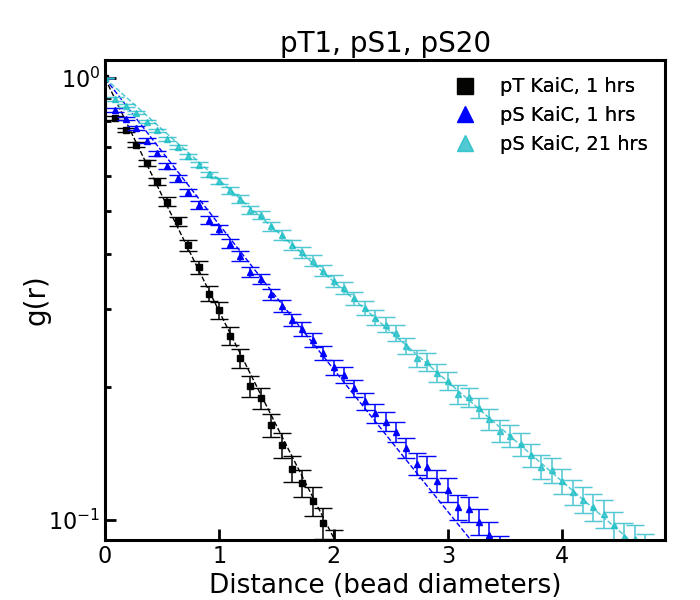

AE
EA
EA


In [152]:
%matplotlib notebook
font_size = 20
fig, ax = plt.subplots(figsize=(7,6))
ax.tick_params(axis='both', direction='in', which='major', length=8, width=2, labelsize=font_size-4)
ax.tick_params(axis='both', direction='in', which='minor', length=4, width=2, labelsize=font_size-4)

marker = 'o'
markerSize = 4.5
marker2 = '--'
linew = 1.0
elinew = 1.1
cap_size = 6.5

lines1 = []                                
lines2 = []
time_arr = []

fk = 3
i=0
marker, cmap, cmap2, data_label = select_cmap(fk)
time = data_label+", "+str(time_array[i])+" hrs"
time_arr.append(time)

cmap = (matplotlib.cm.get_cmap('spring'))(0.99)
ax.plot(x_fit_values, all_avg_fits[fk,i], marker2, linewidth=linew, c=cmap, alpha=(0.01+(i*0.05)))
lines2 += ax.plot(all_xvalues, all_avg_gr[fk,i], marker, ms=markerSize, c=cmap, alpha=(0.01+(i*0.05)), label = time)
ax.errorbar(all_xvalues, all_avg_gr[fk,i], all_gr_stdE[fk,i], fmt = 'none', elinewidth=elinew, capsize=cap_size, 
            c=cmap, alpha=(0.01+(i*0.05))) 
ax.plot(x_fit_values, all_avg_fits[fk,i], marker2, linewidth=linew, c=cmap2(0.995-(i*0.12)), alpha= (0.995-(i*0.09)))
lines1 += ax.plot(all_xvalues, all_avg_gr[fk,i], marker, ms=markerSize, c=cmap2(0.995-(i*0.12)), alpha= (0.995-(i*0.09)))
ax.errorbar(all_xvalues, all_avg_gr[fk,i], all_gr_stdE[fk,i], fmt = 'none', elinewidth=elinew, capsize=cap_size, 
            c=cmap2(0.995-(i*0.12)), alpha= (0.995-(i*0.09)))

fk = 2
i=0
marker, cmap, cmap2, data_label = select_cmap(fk)
time = data_label+", "+str(time_array[i])+" hrs"
time_arr.append(time)
lines2 += ax.plot(all_xvalues, all_avg_gr[fk,i], marker, ms=markerSize, c=cmap, alpha=(0.02+(i*0.03)), label = time)
ax.plot(x_fit_values, all_avg_fits[fk,i], marker2, linewidth=linew, c='b', alpha=0.995)
lines1 += ax.plot(all_xvalues, all_avg_gr[fk,i], marker, ms=markerSize, c='b', alpha=0.995)
ax.errorbar(all_xvalues, all_avg_gr[fk,i], all_gr_stdE[fk,i], fmt = 'none', elinewidth=elinew, capsize=cap_size, 
            c='b', alpha=0.995) 

fk = 2
i=6
marker, cmap, cmap2, data_label = select_cmap(fk)
time = data_label+", "+str(time_array[i])+" hrs"
time_arr.append(time)
ax.plot(x_fit_values, all_avg_fits[fk,i], marker2, linewidth=linew, c=cmap2(0.995-(i*0.122)), alpha=0.995)
lines1 += ax.plot(all_xvalues, all_avg_gr[fk,i], marker, ms=markerSize, c=cmap2(0.995-(i*0.122)), alpha=0.995)
ax.errorbar(all_xvalues, all_avg_gr[fk,i], all_gr_stdE[fk,i], fmt = 'none', elinewidth=elinew, capsize=cap_size, 
            c=cmap2(0.995-(i*0.122)), alpha=0.995)

ax.plot(x_fit_values, all_avg_fits[fk,i], marker2, linewidth=linew, c=cmap, alpha=(0.4+(i*0.03)))
lines2 += ax.plot(all_xvalues, all_avg_gr[fk,i], marker, ms=markerSize, c=cmap, alpha=(0.4+(i*0.03)), label = time)
ax.errorbar(all_xvalues, all_avg_gr[fk,i], all_gr_stdE[fk,i], fmt = 'none', elinewidth=elinew, capsize=cap_size, 
            c=cmap, alpha=(0.4+(i*0.03)))  

ax.set_yscale("log")
ax.set_ylim(0.09, 1.1)
#ax.set_ylim(-0.03, 1.0)

#ax.set_xscale("log")
#ax.set_xlim(0.085, 5.2) 
#ax.set_xlim(0.085, 15)
ax.set_xlim(0.0, 4.9)
#ax.set_xlim(0, 4.8)

    
title =  "pT1, pS1, pS20" #+ " (normalized CDF)"   #"Time = " + str(time) + " hrs,
ax.set_title(title, fontsize= (font_size))
plt.ylabel('g(r)', fontsize=font_size, labelpad = -2)
plt.xlabel('Distance (bead diameters)', fontsize=font_size-1)

leg_loc= 'upper right'  #'lower left' #

leg1 = ax.legend(markerscale=2.5, fontsize=font_size-6, loc = leg_loc, framealpha= 0, frameon=False)
from matplotlib.legend import Legend
leg2 = Legend(ax, lines1, time_arr, markerscale=2.5, fontsize=font_size-6,
             loc=leg_loc, framealpha= 0, frameon=False)
ax.add_artist(leg2)
plt.subplots_adjust(bottom=0.1, left=0.15, right=0.95, top=0.9)
plt.show()

fig.savefig(data_saveto+ "logy Fig3 SIA avg + error + fits "+title+".png", dpi=800, bbox_inches ='tight', transparent=True)
fig.savefig(svg_saveto+ "logy Fig3 SIA avg + error + fits"+title+".svg", dpi=800, bbox_inches ='tight', transparent=True)
#fig.savefig(data_saveto+ "SIA avg + error "+title+".png", dpi=800, bbox_inches ='tight', transparent=True)
#fig.savefig(svg_saveto+ "SIA avg + error "+title+".svg", dpi=800, bbox_inches ='tight', transparent=True)

#fig.savefig(data_saveto+ "all times SIA avg + error + fits "+title+".png", dpi=800, bbox_inches ='tight', transparent=True)
#fig.savefig(svg_saveto+ "all times SIA avg + error + fits"+title+".svg", dpi=800, bbox_inches ='tight', transparent=True)
#fig.savefig(data_saveto+ "all times SIA avg + error "+title+".png", dpi=800, bbox_inches ='tight', transparent=True)
#fig.savefig(svg_saveto+ "all times SIA avg + error "+title+".svg", dpi=800, bbox_inches ='tight', transparent=True)

In [64]:
def select_cmap(frame_key):
    if frame_key == 0:
        print("50% bKaiB")
        return 'o', 'm', matplotlib.cm.get_cmap('RdPu'), "50% bKaiB" 
    elif frame_key == 1:
        print("35% bKaiB")
        return '<', 'darkorange', matplotlib.cm.get_cmap('Oranges'), "35% bKaiB"
    elif frame_key == 2:
        print("20% bKaiB")
        return '>', 'hotpink', matplotlib.cm.get_cmap('Greens'), "20% bKaiB"
    elif frame_key == 3:
        print("pT (20% bKaiB)")
        return 's', 'k', matplotlib.cm.get_cmap('gist_yarg'),  "pT (20% bKaiB)" 

<IPython.core.display.Javascript object>


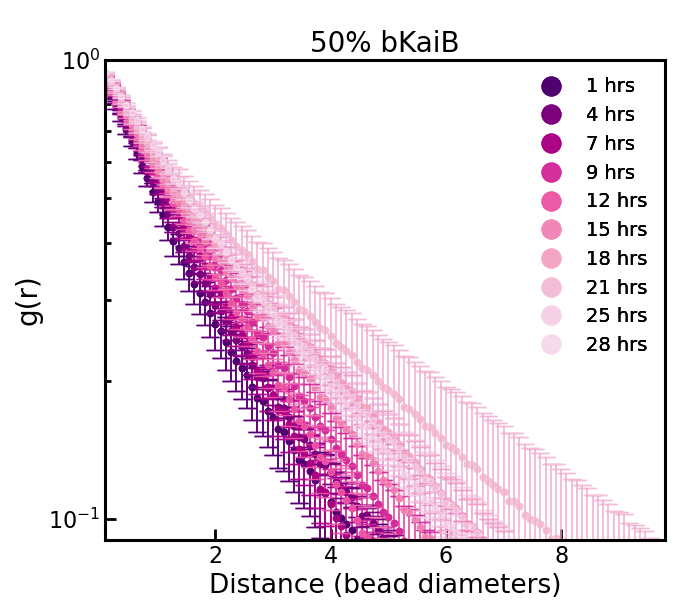

50% bKaiB


In [73]:
%matplotlib notebook
font_size = 20
fig, ax = plt.subplots(figsize=(7,6))
ax.tick_params(axis='both', direction='in', which='major', length=8, width=2, labelsize=font_size-4)
ax.tick_params(axis='both', direction='in', which='minor', length=4, width=2, labelsize=font_size-4)

marker = 'o'
mS = 4.5
marker2 = '--'
linew = 1.0
elinew = 1.1
cap_size = 6.5

fk = 0
#### up to 28 hrs
#WT=> 'RdPu' cmap2(0.995-(i*0.122)), alpha=0.995)    cmap, alpha=(0.02+(i*0.03))
#EA=> 'Blues'  cmap2(0.995-(i*0.122)), alpha=0.995)    cmap, alpha=(0.02+(i*0.039))
#AE=> cmap= 'spring'  cmap2= 'gist_yarg' cmap2(0.995-(i*0.12)), alpha= (0.995-(i*0.09))  cmap, alpha=(0.01+(i*0.05))
marker, cmap, cmap2, data_label = select_cmap(fk)
lines1 = []                                
lines2 = []
lines3 = []
time_arr = []
for i in range(0,10,1):
    time = str(time_array[i])+" hrs"
    time_arr.append(time)
    
    '''  #AE:
    cmap = (matplotlib.cm.get_cmap('spring'))(0.99)
    lines1 += ax.plot(all_xvalues, all_avg_gr[fk,i], marker, ms=mS, c=cmap2(0.99-(i*0.12)), alpha=(0.979-((i-1)*0.02)))
    ax.errorbar(all_xvalues, all_avg_gr[fk,i], all_gr_stdE[fk,i], fmt = 'none', elinewidth=elinew, capsize=cap_size, 
                c=cmap2(0.99-(i*0.12)), alpha=(0.979-((i-1)*0.02)))
    lines2 += ax.plot(all_xvalues, all_avg_gr[fk,i], marker, ms=mS, c=cmap, alpha=(0.08+((i-1)*0.07)))
    ax.errorbar(all_xvalues, all_avg_gr[fk,i], all_gr_stdE[fk,i], fmt = 'none', elinewidth=elinew, capsize=cap_size, 
                c=cmap, alpha=(0.08+((i-1)*0.07)))
    lines3 += ax.plot(all_xvalues, all_avg_gr[fk,i], marker, ms=mS, c=cmap2(0.999-(i*0.12)), alpha=0)
    ax.errorbar(all_xvalues, all_avg_gr[fk,i], all_gr_stdE[fk,i], fmt = 'none', elinewidth=elinew, capsize=cap_size, 
                c=cmap2(0.999-(i*0.12)), alpha=0)  #    '''
    '''  #WT:
    lines1 += ax.plot(all_xvalues, all_avg_gr[fk,i], marker, ms=mS, c=cmap, alpha=(0.99-(i*0.092)))
    ax.errorbar(all_xvalues, all_avg_gr[fk,i], all_gr_stdE[fk,i], fmt = 'none', elinewidth=elinew, capsize=cap_size, 
                c=cmap, alpha=(0.99-(i*0.092)))
    lines2 += ax.plot(all_xvalues, all_avg_gr[fk,i], marker, ms=mS, c=cmap2(0.999-(i*0.123)), alpha=(0.6-((i-1)*0.07)))
    ax.errorbar(all_xvalues, all_avg_gr[fk,i], all_gr_stdE[fk,i], fmt = 'none', elinewidth=elinew, capsize=cap_size, 
                c=cmap2(0.999-(i*0.123)), alpha=(0.6-((i-1)*0.07)))
    lines3 += ax.plot(all_xvalues, all_avg_gr[fk,i], marker, ms=mS, c=cmap2(0.999-(i*0.124)), alpha=(0.6-((i-2)*0.085)))
    ax.errorbar(all_xvalues, all_avg_gr[fk,i], all_gr_stdE[fk,i], fmt = 'none', elinewidth=elinew, capsize=cap_size, 
                c=cmap2(0.999-(i*0.124)), alpha=(0.6-((i-2)*0.085)))  #    '''

      #EA:
    lines1 += ax.plot(all_xvalues, all_avg_gr[fk,i], marker, ms=mS, c=cmap, alpha=(0.99-(i*0.08)))
    ax.errorbar(all_xvalues, all_avg_gr[fk,i], all_gr_stdE[fk,i], fmt = 'none', elinewidth=elinew, capsize=cap_size, 
                c=cmap, alpha=(0.99-(i*0.08)))
    lines2 += ax.plot(all_xvalues, all_avg_gr[fk,i], marker, ms=mS, c=cmap2(0.999-(i*0.1)), alpha=(0.6-((i-2)*0.04)))
    ax.errorbar(all_xvalues, all_avg_gr[fk,i], all_gr_stdE[fk,i], fmt = 'none', elinewidth=elinew, capsize=cap_size, 
                c=cmap2(0.999-(i*0.1)), alpha=(0.6-((i-2)*0.04)))
    lines3 += ax.plot(all_xvalues, all_avg_gr[fk,i], marker, ms=mS, c=cmap2(0.999-(i*0.124)), alpha=(0.7-((i-2)*0.045)))
    ax.errorbar(all_xvalues, all_avg_gr[fk,i], all_gr_stdE[fk,i], fmt = 'none', elinewidth=elinew, capsize=cap_size, 
                c=cmap2(0.999-(i*0.124)), alpha=(0.7-((i-2)*0.045)))  #    '''

ax.set_yscale("log")
ax.set_ylim(0.09, 1.0)
#ax.set_ylim(-0.03, 1.0)

#ax.set_xscale("log")
ax.set_xlim(0.085, 9.8) 
#ax.set_xlim(0.085, 5)
#ax.set_xlim(0, 4.8)
    
title =  data_label #+ " (normalized CDF)"   #"Time = " + str(time) + " hrs,
ax.set_title(title, fontsize= (font_size))
plt.ylabel('g(r)', fontsize=font_size)
plt.xlabel('Distance (bead diameters)', fontsize=font_size-1)


#leg1 = ax.legend(markerscale=3., fontsize=font_size-6, loc = 'upper right', framealpha= 0, frameon=False)
from matplotlib.legend import Legend
leg1 = Legend(ax, lines1, time_arr, markerscale=3., fontsize=font_size-6,
             loc='upper right', framealpha= 0, frameon=False)
leg2 = Legend(ax, lines2, time_arr, markerscale=3., fontsize=font_size-6,
             loc='upper right', framealpha= 0, frameon=False)
leg3 = Legend(ax, lines3, time_arr, markerscale=3., fontsize=font_size-6,
             loc='upper right', framealpha= 0, frameon=False)
ax.add_artist(leg1)
ax.add_artist(leg2)
ax.add_artist(leg3)
plt.subplots_adjust(bottom=0.1, left=0.15, right=0.95, top=0.9)
#ax.axhline((1/np.exp(1)))
plt.show()

title =  data_label + " (average g(r))"   #, transparent=True
fig.savefig(data_saveto+ "bKaiB control SIA avg + error + fits "+title+".png", dpi=800, bbox_inches ='tight')
fig.savefig(svg_saveto+ "bKaiB control SIA avg + error + fits"+title+".svg", dpi=800, bbox_inches ='tight')
#fig.savefig(data_saveto+ "logy SIA avg + error "+title+".png", dpi=800, bbox_inches ='tight', transparent=True)
#fig.savefig(svg_saveto+ "logy SIA avg + error "+title+".svg", dpi=800, bbox_inches ='tight', transparent=True)

#fig.savefig(data_saveto+ "all times SIA avg + error + fits "+title+".png", dpi=800, bbox_inches ='tight')
#fig.savefig(svg_saveto+ "all times SIA avg + error + fits"+title+".svg", dpi=800, bbox_inches ='tight')
#fig.savefig(data_saveto+ "all times SIA avg + error "+title+".png", dpi=800, bbox_inches ='tight')
#fig.savefig(svg_saveto+ "all times SIA avg + error "+title+".svg", dpi=800, bbox_inches ='tight')

<IPython.core.display.Javascript object>


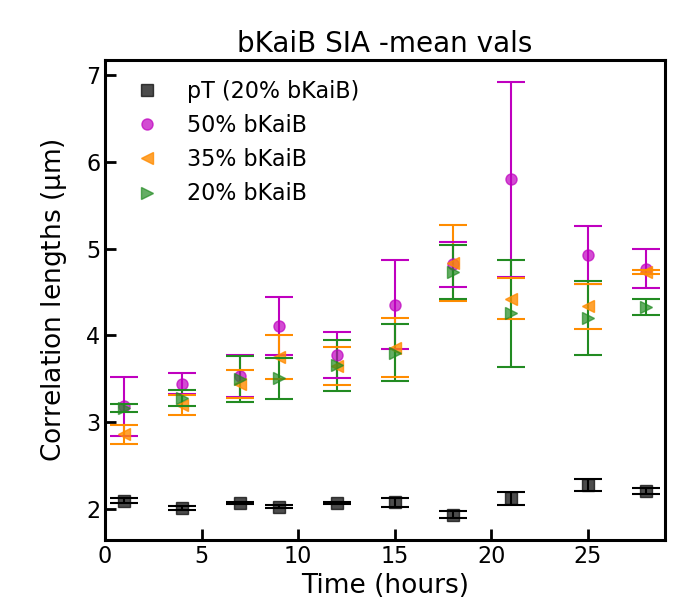

pT (20% bKaiB)
50% bKaiB
35% bKaiB
20% bKaiB


In [68]:
%matplotlib notebook
font_size = 20
fig, ax = plt.subplots(figsize=(7,6))
ax.tick_params(axis='both', direction='in', which='major', length=8, width=2, labelsize=font_size-4)
ax.tick_params(axis='both', direction='in', which='minor', length=4, width=2, labelsize=font_size-4)

this_plot = 'Correlation lengths ($\mu$m)'  
#'mean cluster size ($\mu$m$^{{2}}$)'  #'clusters found (number)' #'FW at 10% max ($\mu$m$^{{2}}$)'
this_plot_s = "(FP overlay) "+ this_plot.split(' ')[0] + " " + this_plot.split(' ')[1]

end_index = 10
y_array = all_avg_cl  #all_avg_A[fk,i], all_avg_cl[fk,i]
y_stdE = all_cl_stdE   #all_A_stdE[fk,i], all_cl_stdE[fk,i]
s_time_array = time_array

title = "bKaiB SIA -mean vals" 
ax.set_title(title, fontsize= (font_size))

ax.set_ylabel(this_plot, fontsize=font_size-1, labelpad= 12)
#ax.tick_params(axis='y', direction='in', which='major', length=8, width=2, labelsize=font_size-6)
#ax.set_ylim(1.4, 5.1)
#ax.set_yscale("log")

ax.set_xlabel('Time (hours)', fontsize=font_size-1)
ax.set_xlim(0, 29)

markerSize = 8
markerSize2 = 5
elinew = 1.5
x=2
x2=2

###########################################################################
###########################################################################
fk = 3
marker, cmap, cmap2, data_label = select_cmap(fk)
#marker = '--'+marker
ax.plot(s_time_array, y_array[fk]*x,marker, ms=markerSize, c=cmap, alpha=0.7, label = data_label)
ax.errorbar(s_time_array, y_array[fk]*x, yerr = y_stdE[fk]*x2, fmt = 'none', capthick=elinew, ecolor=cmap, capsize=10)

fk = 0
marker, cmap, cmap2, data_label = select_cmap(fk)
ax.plot(s_time_array, y_array[fk]*x,marker, ms=markerSize, c=cmap, alpha=0.7, label = data_label)
ax.errorbar(s_time_array, y_array[fk]*x, yerr = y_stdE[fk]*x2, fmt = 'none', capthick=elinew, ecolor=cmap, capsize=10)

fk = 1
marker, cmap, cmap2, data_label = select_cmap(fk)
cmap = 'darkorange'
ax.plot(s_time_array, y_array[fk]*x,marker, ms=markerSize, c=cmap, alpha=0.8, label = data_label)
ax.errorbar(s_time_array, y_array[fk]*x, yerr = y_stdE[fk]*x2, fmt = 'none', capthick=elinew, ecolor=cmap, capsize=10)

fk = 2
marker, cmap, cmap2, data_label = select_cmap(fk)
cmap = 'forestgreen'
ax.plot(s_time_array, y_array[fk]*x,marker, ms=markerSize, c=cmap, alpha=0.7, label = data_label)
ax.errorbar(s_time_array, y_array[fk]*x, yerr = y_stdE[fk]*x2, fmt = 'none', capthick=elinew, ecolor=cmap, capsize=10)
###########################################################################
###########################################################################

plt.subplots_adjust(bottom=0.1, left=0.15, right=0.95, top=0.9)             
ax.legend(fontsize=font_size-4, framealpha= 0, frameon=False)
#ax2.legend(fontsize=font_size-4, framealpha= 0, frameon=False)
plt.show()

fig.savefig(data_saveto+this_plot_s+".jpg", dpi=800, transparent=True)
fig.savefig(svg_saveto+this_plot_s+".svg", dpi=800, transparent=True)

In [ ]:
%matplotlib notebook
font_size = 20
fig, ax = plt.subplots(figsize=(7,6))
ax.tick_params(axis='both', direction='in', which='major', length=8, width=2, labelsize=font_size-4)
ax.tick_params(axis='both', direction='in', which='minor', length=4, width=2, labelsize=font_size-4)

this_plot = 'Correlation lengths ($\mu$m)'  
#'mean cluster size ($\mu$m$^{{2}}$)'  #'clusters found (number)' #'FW at 10% max ($\mu$m$^{{2}}$)'
this_plot_s = "(FP overlay) "+ this_plot.split(' ')[0] + " " + this_plot.split(' ')[1]

end_index = 10
y_array = all_avg_cl  #all_avg_A[fk,i], all_avg_cl[fk,i]
y_stdE = all_cl_stdE   #all_A_stdE[fk,i], all_cl_stdE[fk,i]
s_time_array = time_array

title = "bKaiB SIA -mean vals" 
ax.set_title(title, fontsize= (font_size))

ax.set_ylabel(this_plot, fontsize=font_size-1, labelpad= 12)
#ax.tick_params(axis='y', direction='in', which='major', length=8, width=2, labelsize=font_size-6)
#ax.set_ylim(1.4, 5.1)
#ax.set_yscale("log")

ax.set_xlabel('Time (hours)', fontsize=font_size-1)
ax.set_xlim(0, 29)

mS = 8
markerSize2 = 5
elinew = 1.5
x=2
x2=2

###########################################################################
###########################################################################
fk = 0
marker, cmap, cmap2, data_label = select_cmap(fk)
i=0
ax.plot(s_time_array, y_array[fk]*x,marker, ms=mS, c=cmap, alpha=(0.99-(i*0.08)), label = data_label)
ax.plot(s_time_array, y_array[fk]*x,marker, ms=mS, c=cmap2(0.999-(i*0.1)), alpha=(0.6-((i-2)*0.04)), label=data_label)
ax.errorbar(s_time_array, y_array[fk]*x, yerr = y_stdE[fk]*x2, fmt = 'none', 
            capthick=elinew, ecolor=cmap, alpha=(0.99-(i*0.08)), capsize=10)
ax.errorbar(s_time_array, y_array[fk]*x, yerr = y_stdE[fk]*x2, fmt = 'none', 
            capthick=elinew, ecolor=cmap2(0.999-(i*0.1)), alpha=(0.6-((i-2)*0.04)), capsize=10)

fk = 1
marker, cmap, cmap2, data_label = select_cmap(fk)
i=2
ax.plot(s_time_array, y_array[fk]*x,marker, ms=mS, c=cmap, alpha=(0.99-(i*0.08)), label = data_label)
ax.plot(s_time_array, y_array[fk]*x,marker, ms=mS, c=cmap2(0.999-(i*0.1)), alpha=(0.6-((i-2)*0.04)), label=data_label)
ax.errorbar(s_time_array, y_array[fk]*x, yerr = y_stdE[fk]*x2, fmt = 'none', 
            capthick=elinew, ecolor=cmap, alpha=(0.99-(i*0.08)), capsize=10)
ax.errorbar(s_time_array, y_array[fk]*x, yerr = y_stdE[fk]*x2, fmt = 'none', 
            capthick=elinew, ecolor=cmap2(0.999-(i*0.1)), alpha=(0.6-((i-2)*0.04)), capsize=10)

fk = 2
marker, cmap, cmap2, data_label = select_cmap(fk)
i=4
ax.plot(s_time_array, y_array[fk]*x,marker, ms=mS, c=cmap, alpha=(0.99-(i*0.08)), label = data_label)
ax.plot(s_time_array, y_array[fk]*x,marker, ms=mS, c=cmap2(0.999-(i*0.1)), alpha=(0.6-((i-2)*0.04)), label=data_label)
ax.errorbar(s_time_array, y_array[fk]*x, yerr = y_stdE[fk]*x2, fmt = 'none', 
            capthick=elinew, ecolor=cmap, alpha=(0.99-(i*0.08)), capsize=10)
ax.errorbar(s_time_array, y_array[fk]*x, yerr = y_stdE[fk]*x2, fmt = 'none', 
            capthick=elinew, ecolor=cmap2(0.999-(i*0.1)), alpha=(0.6-((i-2)*0.04)), capsize=10)

fk = 3
marker, cmap, cmap2, data_label = select_cmap(fk)
#marker = '--'+marker
ax.plot(s_time_array, y_array[fk]*x,marker, ms=mS, c=cmap, label = data_label)
ax.errorbar(s_time_array, y_array[fk]*x, yerr = y_stdE[fk]*x2, fmt = 'none', capthick=elinew, ecolor=cmap, capsize=10)
###########################################################################
###########################################################################

plt.subplots_adjust(bottom=0.1, left=0.15, right=0.95, top=0.9)             
ax.legend(fontsize=font_size-4, framealpha= 0, frameon=False)
#ax2.legend(fontsize=font_size-4, framealpha= 0, frameon=False)
plt.show()

fig.savefig(data_saveto+this_plot_s+".jpg", dpi=800, transparent=True)
fig.savefig(svg_saveto+this_plot_s+".svg", dpi=800, transparent=True)

In [159]:
import csv

sim_time = []
sim_control = []
sim_control_SE = []
sim_static = []
sim_static_SE = []

sim_p1 = []
sim_p1_SE = []
sim_p2 = []
sim_p2_SE = []
sim_p3 = []
sim_p3_SE = []

with open("Lauren's CL data (MeanSE).csv") as csvfile:
    reader = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC) # change contents to floats
    for row in reader: # each row is a list
        #print(row[0], row[1], row[2], row[5], row[6], row[7], row[8])
        sim_time.append(row[0])
        sim_control.append(row[1])
        sim_control_SE.append(row[2])
        sim_p1.append(row[3])
        sim_p1_SE.append(row[4])
        sim_p2.append(row[5])
        sim_p2_SE.append(row[6])
        sim_p3.append(row[7])
        sim_p3_SE.append(row[8])
        sim_static.append(row[9])
        sim_static_SE.append(row[10])

<IPython.core.display.Javascript object>


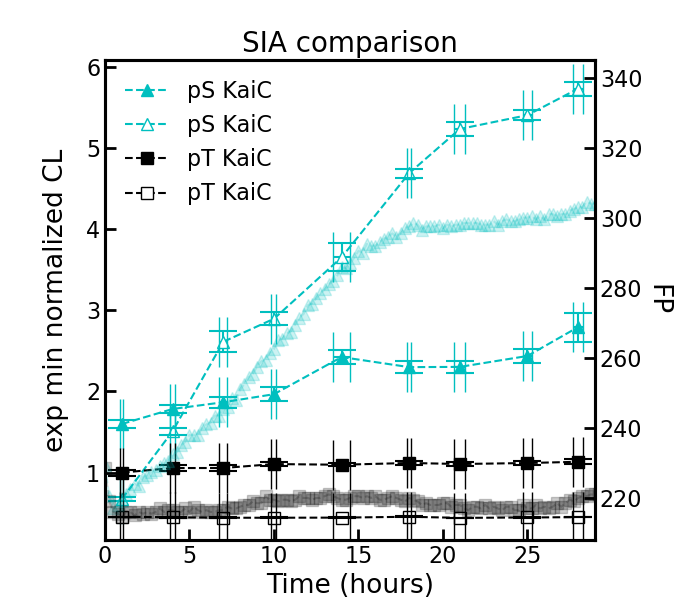

1.6565533979325802 1.6565533979325802
[[1.13951282 1.28813461 1.34877778 1.38504078 1.53307582 1.6037525
  1.5962415  1.68227355 1.7512912 ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [1.32415117 1.47710947 1.5458409  1.62785014 2.00685174 1.90411502
  1.90649732 2.01770933 2.31236162]
 [0.8282767  0.87445893 0.87497154 0.91517502 0.90802977 0.92631442
  0.9155751  0.92570788 0.93842816]]
EA
AE


In [192]:
%matplotlib notebook
font_size = 20
fig, ax = plt.subplots(figsize=(7,6))
ax.tick_params(axis='both', direction='in', which='major', length=8, width=2, labelsize=font_size-4)
ax.tick_params(axis='both', direction='in', which='minor', length=4, width=2, labelsize=font_size-4)
ax2 = ax.twinx()
ax2.tick_params(axis='both', direction='in', which='major', length=8, width=2, labelsize=font_size-4)
ax2.tick_params(axis='both', direction='in', which='minor', length=8, width=2, labelsize=font_size-4)

  
#'mean cluster size ($\mu$m$^{{2}}$)'  #'clusters found (number)' #'FW at 10% max ($\mu$m$^{{2}}$)'
#this_plot_s = "(FP overlay) EA, AE"+ this_plot.split(' ')[0] + " " + this_plot.split(' ')[1]

end_index = 9
y_array = all_avg_cl  #all_avg_A[fk,i], all_avg_cl[fk,i], all_median_cl
y_stdE = all_cl_stdE   #all_A_stdE[fk,i], all_cl_stdE[fk,i]
s_time_array = time_array


#ax.tick_params(axis='y', direction='in', which='major', length=8, width=2, labelsize=font_size-6)
#ax.set_ylim(1.4, 4.9)
#ax.set_yscale("log")

#ax2.yaxis.set_rotate_label(False)  # disable automatic rotation
ax2.set_ylabel('FP', rotation = -90, fontsize=font_size-1, labelpad= 20) #, labelpad= 0, ha='center', va='center'
#ax2.set_ylim(208, 345)

ax.set_xlabel('Time (hours)', fontsize=font_size-1)
ax.set_xlim(0, 29)

markerSize = 8
markerSize2 = 8
elinew = 1.5
xelinew = 1

###########################################################################
###########################################################################
x=2
x2=2

'''fk = 0
marker, cmap, cmap2, data_label = select_cmap(fk)
marker = '--'+marker
ax.plot(s_time_array, y_array[fk]*2,marker, ms=markerSize, c=cmap, label = data_label)
ax.errorbar(s_time_array, y_array[fk]*2, yerr = y_stdE[fk]*2, fmt = 'none', capthick=elinew, ecolor=cmap, capsize=10)
ax.errorbar(s_time_array, y_array[fk]*x, xerr = time_stdE, fmt = 'none', capthick=xelinew, ecolor=cmap, capsize=18)
ax2.plot(FP_time, FP_WTkA_r1, marker, ms=markerSize2, c=cmap, alpha = 0.2, label = "FP "+data_label)
ax2.plot(FP_time, FP_WTkA_r2, marker, ms=markerSize2, c=cmap, alpha = 0.2)
'''

max_val = (all_avg_cl[3][0]*2) #(sim_control[0]) #
#max_val =  1 #max((all_avg_cl[2] *2)) #max(sim_static) #max((all_avg_cl[2] *2)) 
y_array = all_avg_cl/max_val
y_stdE = all_cl_stdE/max_val

max_val2 = (sim_control[0]) #(all_avg_cl[3][0]) #
#max_val2 = 1 #max((all_avg_cl[2] *2)) #max(sim_static) #max((all_avg_cl[2] *2)) #
print(max_val, max_val2)
print(all_avg_cl)


fk = 2
marker, cmap, cmap2, data_label = select_cmap(fk)
marker = '--'+marker
ax.plot(s_time_array, y_array[fk]*x,marker, ms=markerSize, c=cmap, label = data_label)
ax.errorbar(s_time_array, y_array[fk]*x, yerr = y_stdE[fk]*x2, fmt = 'none', capthick=elinew, ecolor=cmap, capsize=10)
ax.errorbar(s_time_array, y_array[fk]*x, xerr = time_stdE, fmt = 'none', capthick=xelinew, ecolor=cmap, capsize=18)

ax.plot(sim_time, np.array(sim_static)/max_val2, marker, ms=markerSize, c=cmap, mfc='w', label = data_label)
ax.errorbar(s_time_array, np.array(sim_static)/max_val2, yerr = np.array(sim_static_SE)/max_val2, 
            fmt = 'none', capthick=elinew, ecolor=cmap, capsize=10)
ax.errorbar(s_time_array, np.array(sim_static)/max_val2, xerr = time_stdE, fmt = 'none', 
            capthick=xelinew, ecolor=cmap, capsize=18)

ax2.plot(FP_time, FP_EA_avg, marker, ms=markerSize2, c=cmap, alpha = 0.2, label = "FP "+data_label)

fk = 3
marker, cmap, cmap2, data_label = select_cmap(fk)
marker = '--'+marker
ax.plot(s_time_array, y_array[fk]*x,marker, ms=markerSize, c=cmap, label = data_label)
ax.errorbar(s_time_array, y_array[fk]*x, yerr = y_stdE[fk]*x2, fmt = 'none', capthick=elinew, ecolor=cmap, capsize=10)
ax.errorbar(s_time_array, y_array[fk]*x, xerr = time_stdE, fmt = 'none', capthick=xelinew, ecolor=cmap, capsize=18)

ax.plot(sim_time, np.array(sim_control)/max_val2, marker, ms=markerSize, c=cmap, mfc='w', label = data_label)
ax.errorbar(s_time_array, np.array(sim_control)/max_val2, yerr = np.array(sim_control_SE)/max_val2, 
            fmt = 'none', capthick=elinew, ecolor=cmap, capsize=10)
ax.errorbar(s_time_array, np.array(sim_control)/max_val2, xerr = time_stdE, fmt = 'none', 
            capthick=xelinew, ecolor=cmap, capsize=18)

ax2.plot(FP_time, FP_AE_avg, marker, ms=markerSize2, c=cmap, alpha = 0.2, label = "FP "+data_label)
###########################################################################
###########################################################################
#ax.set_ylim(1.4, 5.1)
ax2.set_ylim(208, 345)

title = "SIA comparison" 
ax.set_title(title, fontsize= (font_size))
this_plot = 'exp min normalized CL' #
ax.set_ylabel(this_plot, fontsize=font_size-1, labelpad= 12)
this_plot_s = "exp vs sim EA, AE"+ this_plot

plt.subplots_adjust(bottom=0.1, left=0.15, right=0.85, top=0.9)             
ax.legend(fontsize=font_size-4, framealpha= 0, frameon=False, loc='upper left')
#ax2.legend(fontsize=font_size-4, framealpha= 0, frameon=False)
plt.show()

fig.savefig(data_saveto+this_plot_s+".jpg", dpi=800, transparent=True)
fig.savefig(svg_saveto+this_plot_s+".svg", dpi=800, transparent=True)

In [98]:
import csv

FP_time = []
FP_WTkA_r1 = []
FP_WTkA_r2 = []
FP_EA_r1 = []
FP_EA_r2 = []
FP_AE_r1 = []
FP_AE_r2 = []

FP_EA_avg = []
FP_AE_avg = []
FP_WT_avg = []
with open("formatted Michelle's FP data.csv") as csvfile:
    reader = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC) # change contents to floats
    for row in reader: # each row is a list
        #print(row[0], row[1], row[2], row[5], row[6], row[7], row[8])
        FP_time.append(row[0])
        FP_WTkA_r1.append(row[1])
        FP_WTkA_r2.append(row[2])
        FP_EA_r1.append(row[5])
        FP_EA_r2.append(row[6])
        FP_AE_r1.append(row[7])
        FP_AE_r2.append(row[8])
        WT_avg = (row[1] + row[2])/2
        EA_avg = (row[5] + row[6])/2
        AE_avg = (row[7] + row[8])/2
        FP_EA_avg.append(EA_avg)
        FP_AE_avg.append(AE_avg)
        FP_WT_avg.append(WT_avg)

<IPython.core.display.Javascript object>


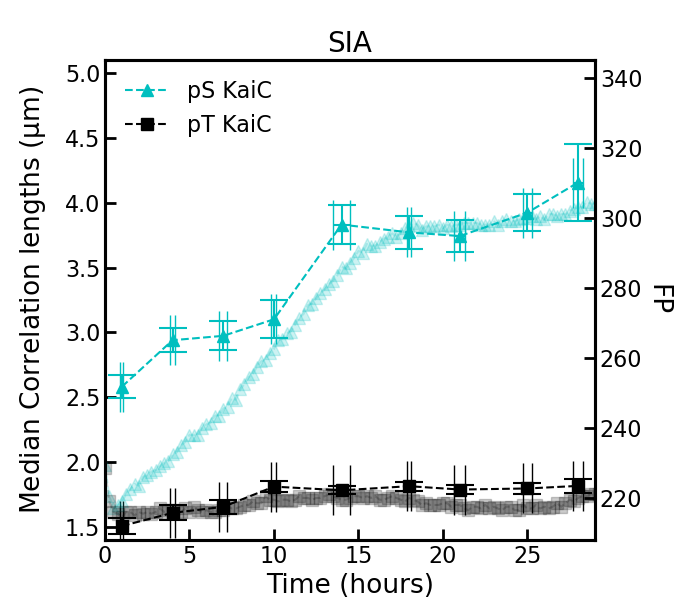

EA
AE


In [106]:
%matplotlib notebook
font_size = 20
fig, ax = plt.subplots(figsize=(7,6))
ax.tick_params(axis='both', direction='in', which='major', length=8, width=2, labelsize=font_size-4)
ax.tick_params(axis='both', direction='in', which='minor', length=4, width=2, labelsize=font_size-4)
ax2 = ax.twinx()
ax2.tick_params(axis='both', direction='in', which='major', length=8, width=2, labelsize=font_size-4)
ax2.tick_params(axis='both', direction='in', which='minor', length=8, width=2, labelsize=font_size-4)

this_plot = 'Median Correlation lengths ($\mu$m)'  
#'mean cluster size ($\mu$m$^{{2}}$)'  #'clusters found (number)' #'FW at 10% max ($\mu$m$^{{2}}$)'
this_plot_s = "(FP overlay) EA, AE"+ this_plot.split(' ')[0] + " " + this_plot.split(' ')[1]

end_index = 9
y_array = all_median_cl  #all_avg_A[fk,i], all_avg_cl[fk,i], all_median_cl
y_stdE = all_cl_stdE   #all_A_stdE[fk,i], all_cl_stdE[fk,i]
s_time_array = time_array

title = "SIA" 
ax.set_title(title, fontsize= (font_size))

ax.set_ylabel(this_plot, fontsize=font_size-1, labelpad= 12)
#ax.tick_params(axis='y', direction='in', which='major', length=8, width=2, labelsize=font_size-6)
#ax.set_ylim(1.4, 4.9)
ax.set_ylim(1.4, 5.1)
#ax.set_yscale("log")

#ax2.yaxis.set_rotate_label(False)  # disable automatic rotation
ax2.set_ylabel('FP', rotation = -90, fontsize=font_size-1, labelpad= 20) #, labelpad= 0, ha='center', va='center'
ax2.set_ylim(208, 345)

ax.set_xlabel('Time (hours)', fontsize=font_size-1)
ax.set_xlim(0, 29)

markerSize = 8
markerSize2 = 8
elinew = 1.5
xelinew = 1
###########################################################################
###########################################################################
x=1
x2=2

'''fk = 0
marker, cmap, cmap2, data_label = select_cmap(fk)
marker = '--'+marker
ax.plot(s_time_array, y_array[fk]*2,marker, ms=markerSize, c=cmap, label = data_label)
ax.errorbar(s_time_array, y_array[fk]*2, yerr = y_stdE[fk]*2, fmt = 'none', capthick=elinew, ecolor=cmap, capsize=10)
ax.errorbar(s_time_array, y_array[fk]*x, xerr = time_stdE, fmt = 'none', capthick=xelinew, ecolor=cmap, capsize=18)
ax2.plot(FP_time, FP_WTkA_r1, marker, ms=markerSize2, c=cmap, alpha = 0.2, label = "FP "+data_label)
ax2.plot(FP_time, FP_WTkA_r2, marker, ms=markerSize2, c=cmap, alpha = 0.2)
'''

fk = 2
marker, cmap, cmap2, data_label = select_cmap(fk)
marker = '--'+marker
ax.plot(s_time_array, y_array[fk]*x,marker, ms=markerSize, c=cmap, label = data_label)
ax.errorbar(s_time_array, y_array[fk]*x, yerr = y_stdE[fk]*x2, fmt = 'none', capthick=elinew, ecolor=cmap, capsize=10)
ax.errorbar(s_time_array, y_array[fk]*x, xerr = time_stdE, fmt = 'none', capthick=xelinew, ecolor=cmap, capsize=18)
ax2.plot(FP_time, FP_EA_avg, marker, ms=markerSize2, c=cmap, alpha = 0.2, label = "FP "+data_label)

fk = 3
marker, cmap, cmap2, data_label = select_cmap(fk)
marker = '--'+marker
ax.plot(s_time_array, y_array[fk]*x,marker, ms=markerSize, c=cmap, label = data_label)
ax.errorbar(s_time_array, y_array[fk]*x, yerr = y_stdE[fk]*x2, fmt = 'none', capthick=elinew, ecolor=cmap, capsize=10)
ax.errorbar(s_time_array, y_array[fk]*x, xerr = time_stdE, fmt = 'none', capthick=xelinew, ecolor=cmap, capsize=18)
ax2.plot(FP_time, FP_AE_avg, marker, ms=markerSize2, c=cmap, alpha = 0.2, label = "FP "+data_label)
###########################################################################
###########################################################################

plt.subplots_adjust(bottom=0.1, left=0.15, right=0.85, top=0.9)             
ax.legend(fontsize=font_size-4, framealpha= 0, frameon=False, loc='upper left')
#ax2.legend(fontsize=font_size-4, framealpha= 0, frameon=False)
plt.show()

fig.savefig(data_saveto+this_plot_s+".jpg", dpi=800, transparent=True)
fig.savefig(svg_saveto+this_plot_s+".svg", dpi=800, transparent=True)

<IPython.core.display.Javascript object>


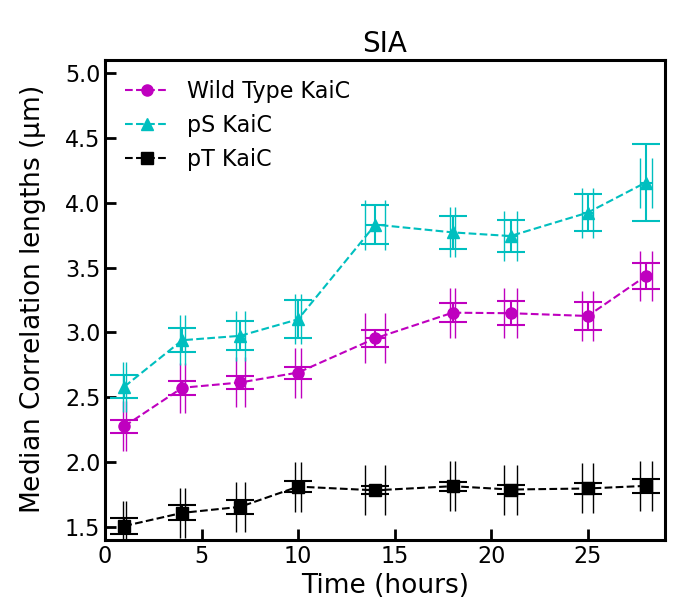

WT+kaiA
EA
AE


In [112]:
%matplotlib notebook
font_size = 20
fig, ax = plt.subplots(figsize=(7,6))
ax.tick_params(axis='both', direction='in', which='major', length=8, width=2, labelsize=font_size-4)
ax.tick_params(axis='both', direction='in', which='minor', length=4, width=2, labelsize=font_size-4)

this_plot = 'Median Correlation lengths ($\mu$m)'  
#'mean cluster size ($\mu$m$^{{2}}$)'  #'clusters found (number)' #'FW at 10% max ($\mu$m$^{{2}}$)'
this_plot_s = "all "+ this_plot.split(' ')[0] + " " + this_plot.split(' ')[1]

end_index = 9
y_array = all_median_cl  #all_avg_A[fk,i], all_avg_cl[fk,i], all_median_cl
y_stdE = all_cl_stdE   #all_A_stdE[fk,i], all_cl_stdE[fk,i]
s_time_array = time_array

title = "SIA" 
ax.set_title(title, fontsize= (font_size))

ax.set_ylabel(this_plot, fontsize=font_size-1, labelpad= 12)
#ax.tick_params(axis='y', direction='in', which='major', length=8, width=2, labelsize=font_size-6)
#ax.set_ylim(1.4, 4.9)
ax.set_ylim(1.4, 5.1)
#ax.set_yscale("log")

ax.set_xlabel('Time (hours)', fontsize=font_size-1)
ax.set_xlim(0, 29)

markerSize = 8
markerSize2 = 8
elinew = 1.5
xelinew = 1

###########################################################################
###########################################################################
x=1
x2=2

fk = 0
marker, cmap, cmap2, data_label = select_cmap(fk)
marker = '--'+marker
ax.plot(s_time_array, y_array[fk]*x,marker, ms=markerSize, c=cmap, label = data_label)
ax.errorbar(s_time_array, y_array[fk]*x, yerr = y_stdE[fk]*2, fmt = 'none', capthick=elinew, ecolor=cmap, capsize=10)
ax.errorbar(s_time_array, y_array[fk]*x, xerr = time_stdE, fmt = 'none', capthick=xelinew, ecolor=cmap, capsize=18)

fk = 2
marker, cmap, cmap2, data_label = select_cmap(fk)
marker = '--'+marker
ax.plot(s_time_array, y_array[fk]*x,marker, ms=markerSize, c=cmap, label = data_label)
ax.errorbar(s_time_array, y_array[fk]*x, yerr = y_stdE[fk]*x2, fmt = 'none', capthick=elinew, ecolor=cmap, capsize=10)
ax.errorbar(s_time_array, y_array[fk]*x, xerr = time_stdE, fmt = 'none', capthick=xelinew, ecolor=cmap, capsize=18)

fk = 3
marker, cmap, cmap2, data_label = select_cmap(fk)
marker = '--'+marker
ax.plot(s_time_array, y_array[fk]*x,marker, ms=markerSize, c=cmap, label = data_label)
ax.errorbar(s_time_array, y_array[fk]*x, yerr = y_stdE[fk]*x2, fmt = 'none', capthick=elinew, ecolor=cmap, capsize=10)
ax.errorbar(s_time_array, y_array[fk]*x, xerr = time_stdE, fmt = 'none', capthick=xelinew, ecolor=cmap, capsize=18)
###########################################################################
###########################################################################

plt.subplots_adjust(bottom=0.1, left=0.15, right=0.95, top=0.9)             
ax.legend(fontsize=font_size-4, framealpha= 0, frameon=False, loc='upper left')
#ax2.legend(fontsize=font_size-4, framealpha= 0, frameon=False)
plt.show()

fig.savefig(data_saveto+this_plot_s+".jpg", dpi=800, transparent=True)
fig.savefig(svg_saveto+this_plot_s+".svg", dpi=800, transparent=True)

In [158]:
cl_array = np.zeros((num_times,18))
A_array = np.zeros((num_times,18))

In [193]:
fk = 3
all_A_vals, all_cl_vals, data_label = select_results(fk)
for i in range(num_times):
    for j in range(18):
        cl_array[i][j] = (all_cl_vals[i][j])*2
#print(cl_array[0])
new_cl_array = np.swapaxes(cl_array,0,1)
#print(new_array)

for i in range(num_times):
    for j in range(18):
        A_array[i][j] = (all_A_vals[i][j])*2
#print(cl_array[0])
new_A_array = np.swapaxes(A_array,0,1)
print(new_A_array.shape)
print(new_cl_array[0])

AE
(18, 9)
[1.46199329 1.56127868 1.54628153 1.60627851 1.64055149 1.69172029
 1.64513356 1.79203352 1.84874511]


In [194]:
csv_data_file = "New SIA results "+data_label+".csv"   
header = []
np.savetxt(data_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(data_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow([data_label])
    writer.writerow(["A values"])
    writer.writerow(["1", "4", "7", "10", "14", "18", "21", "25", "28"])
    for i in range(18):
        writer.writerow(new_A_array[i])
    writer.writerow([''])
    writer.writerow([''])
    writer.writerow(["correlation lengths"])
    writer.writerow(["1", "4", "7", "10", "14", "18", "21", "25", "28"])
    for i in range(18):
        writer.writerow(new_cl_array[i])
f.close()

<IPython.core.display.Javascript object>


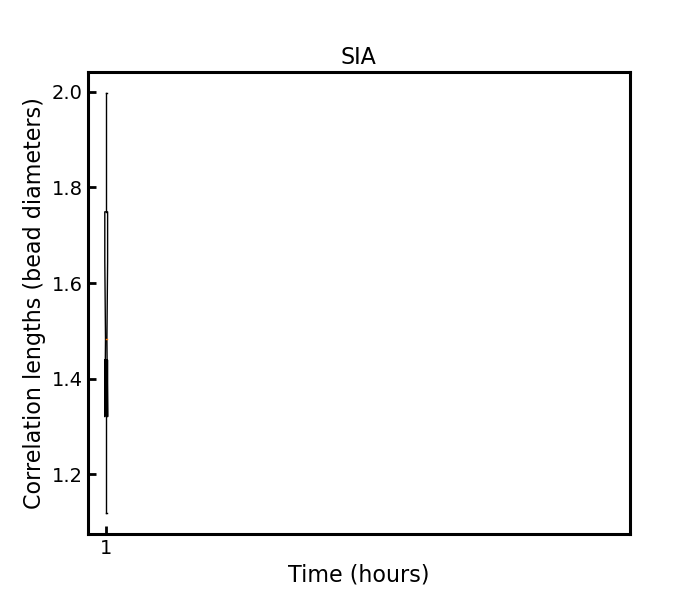

No handles with labels found to put in legend.


AE


In [112]:
%matplotlib notebook
font_size = 20
fig, ax = plt.subplots(figsize=(7,6))
ax.tick_params(axis='both', direction='in', which='major', length=6, width=2, labelsize=font_size-6)
ax.tick_params(axis='both', direction='in', which='minor', length=3, width=2, labelsize=font_size-6)

this_plot = 'Correlation lengths (bead diameters)'  
#'mean cluster size ($\mu$m$^{{2}}$)'  #'clusters found (number)' #'FW at 10% max ($\mu$m$^{{2}}$)'
this_plot_s = "0-28_"+this_plot

end_index = 9
y_array = all_avg_cl  #all_avg_A[fk,i], all_avg_cl[fk,i]
y_stdE = all_cl_stdE   #all_A_stdE[fk,i], all_cl_stdE[fk,i]
s_time_array = time_array

#ax.set_ylim(2, 21)
ax.set_xlim(0, 29)
marker = '--d'
markerSize = 8
font_size = 16
cmap_num = 0.6
#threshold_details = " (clusters >= "+str(beads_per_cluster)+" beads)"
title = "SIA" 

ax.set_title(title, fontsize= (font_size))
plt.ylabel(this_plot, fontsize=font_size)
plt.xlabel('Time (hours)', fontsize=font_size)
ax.ticklabel_format(style='plain')

fk = 3
marker, cmap, all_t_clusters, data_label = select_cmap(fk)
for i in range(num_times):
    for j in range(18):
        array[i][j] = WTkA_all_t_cl_vals[i][j]
new_array = np.swapaxes(array,0,1)
ax.boxplot(new_array[0], marker)

'''fk = 3
cmap, all_t_clusters, data_label = select_cmap(fk)
ax.plot(s_time_array, y_array[fk],marker, ms=markerSize, c=cmap, label = data_label)
ax.errorbar(s_time_array, y_array[fk], yerr = y_stdE[fk], fmt = 'none', ecolor=cmap, capsize=10)
fk = 2
cmap, all_t_clusters, data_label = select_cmap(fk)
ax.plot(s_time_array, y_array[fk],marker, ms=markerSize, c=cmap, label = data_label)
ax.errorbar(s_time_array, y_array[fk], yerr = y_stdE[fk], fmt = 'none', ecolor=cmap, capsize=10)
fk = 0
cmap, all_t_clusters, data_label = select_cmap(fk)
ax.plot(s_time_array, y_array[fk],marker, ms=markerSize, c=cmap, label = data_label)
ax.errorbar(s_time_array, y_array[fk], yerr = y_stdE[fk], fmt = 'none', ecolor=cmap, capsize=10)'''

plt.show()
ax.legend(fontsize=font_size-2, framealpha= 0, frameon=False)
#threshold_details = " (clusters AL "+str(beads_per_cluster)+" beads, bsize= "+str(block_size)+", offset= "+str(offset_val)+")"
#fig.savefig(data_saveto+this_plot_s+threshold_details+".jpg", dpi=800)
#fig.savefig(svg_saveto+this_plot_s+threshold_details+".svg", dpi=800)

## Now we fit the SIA curves to a single exponential, fit equation: y = e^(-x/L1) + A

<IPython.core.display.Javascript object>


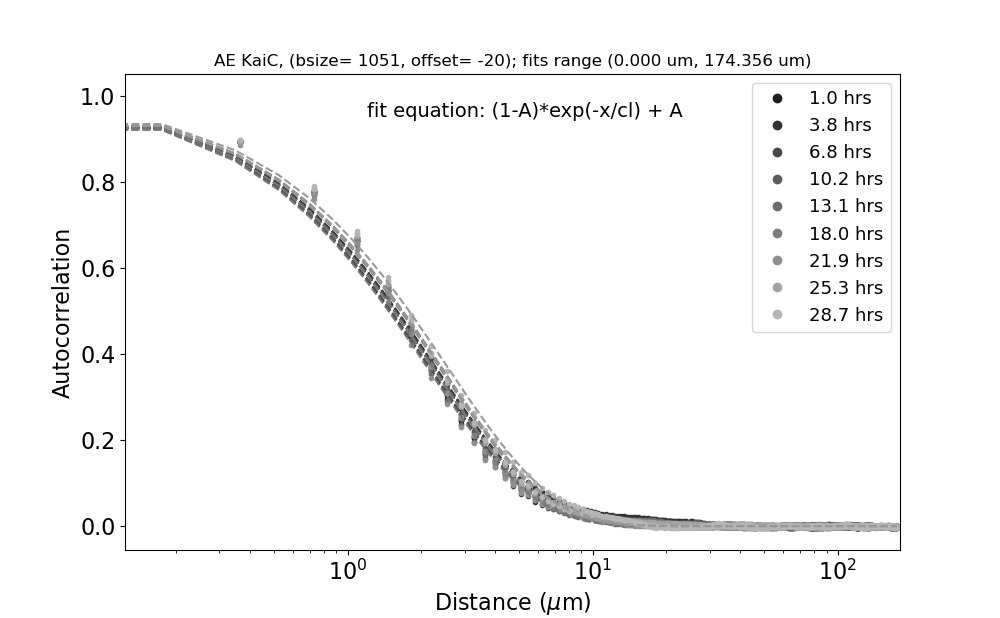

first x-value= 0.364, start fits at 0.000; fit until xlim = 174.356
Fits:
1.0 hrs-- r1 fit: A=0.001, l1=2.236
1.0 hrs-- r2 fit: A=0.001, l1=2.293
1.0 hrs-- r3 fit: A=0.001, l1=2.242
3.8 hrs-- r1 fit: A=0.002, l1=2.398
3.8 hrs-- r2 fit: A=0.001, l1=2.500
3.8 hrs-- r3 fit: A=0.001, l1=2.152
6.8 hrs-- r1 fit: A=-0.000, l1=2.298
6.8 hrs-- r2 fit: A=0.001, l1=2.291
6.8 hrs-- r3 fit: A=0.001, l1=2.246
10.2 hrs-- r1 fit: A=0.000, l1=2.281
10.2 hrs-- r2 fit: A=0.001, l1=2.436
10.2 hrs-- r3 fit: A=0.000, l1=2.251
13.1 hrs-- r1 fit: A=0.000, l1=2.172
13.1 hrs-- r2 fit: A=0.000, l1=2.087
13.1 hrs-- r3 fit: A=0.001, l1=2.236
18.0 hrs-- r1 fit: A=-0.000, l1=2.235
18.0 hrs-- r2 fit: A=-0.000, l1=2.310
18.0 hrs-- r3 fit: A=0.001, l1=2.240
21.9 hrs-- r1 fit: A=0.000, l1=2.118
21.9 hrs-- r2 fit: A=-0.000, l1=2.335
21.9 hrs-- r3 fit: A=-0.000, l1=2.229
25.3 hrs-- r1 fit: A=-0.000, l1=2.374
25.3 hrs-- r2 fit: A=-0.001, l1=2.329
25.3 hrs-- r3 fit: A=0.001, l1=2.421
28.7 hrs-- r1 fit: A=-0.000, l1=2.569
28

<ipython-input-155-38eb18675e2f>:98: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, all_xvalues[fit_lim]+5) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns


Text(0.5, 1.0, 'AE KaiC, (bsize= 1051, offset= -20); fits range (0.000 um, 174.356 um)')

In [155]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 6

### Set up dictionary ("results_dict") and more empty arrays to save results in
results_dict = {}
results_dict["time array"] = time_array

r1_params = [0.0] * arr_length
r2_params = [0.0] * arr_length
r3_params = [0.0] * arr_length

### FIT PARAMETERS: adjust these to change the range for fitting attempts 
fit_start = 0
fit_lim = -1 
retry_num = 10 #retry_num is the number of fitting attempts to try before moving on, not very relevant to single exp fits
x_fit_lim = all_xvalues[fit_lim]
print("first x-value= %5.3f, start fits at %5.3f; fit until xlim = %5.3f" %(all_xvalues[1], all_xvalues[fit_start], x_fit_lim))
print("Fits:")

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" #"time "+(full_filename.split('\\')[-1])[12:-4]

### load and plot the 3 original SIA curves corresponding to 3 tiff files associated with each time point 
    r1_y_array = r1_corr_rad_array[i]
    r2_y_array = r2_corr_rad_array[i]
    r3_y_array = r3_corr_rad_array[i]
    plt.semilogx(all_xvalues,r1_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    #plt.plot(all_xvalues,r2_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)))
    plt.plot(all_xvalues,r3_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)))
    
### x_fit_values has the same range as "all_xvalues", but includes more values to produce better fits
    x_fit_values = np.linspace(all_xvalues[fit_start], all_xvalues[fit_lim], 1000) 

### the "curve_fit" function from scipy does the initial fitting attempt
    r1_popt, r1_pcov = curve_fit(single_exponential, all_xvalues[fit_start:fit_lim], r1_y_array[fit_start:fit_lim])
    r2_popt, r2_pcov = curve_fit(single_exponential, all_xvalues[fit_start:fit_lim], r2_y_array[fit_start:fit_lim])
    r3_popt, r3_pcov = curve_fit(single_exponential, all_xvalues[fit_start:fit_lim], r3_y_array[fit_start:fit_lim])
    print(time+"-- "+'r1 fit: A=%5.3f, l1=%5.3f' % tuple(r1_popt))
    print(time+"-- "+'r2 fit: A=%5.3f, l1=%5.3f' % tuple(r2_popt))
    print(time+"-- "+'r3 fit: A=%5.3f, l1=%5.3f' % tuple(r3_popt))
    r1_A, r1_cl = tuple(r1_popt)
    r2_A, r2_cl = tuple(r2_popt)
    r3_A, r3_cl = tuple(r3_popt)
    
### the "check fits" function re-runs "curve_fit" with a slightly smaller range until the fit parameters meet our criteria
### specified in the "check fits" function, our fit parameters criteria was more relevant for double exponential fits
### (most single exponential fits work first try)
    #r1_A, r1_cl = check_fits(r1_A, r1_cl, r1_y_array, retry_num)
    #r2_A, r2_cl = check_fits(r2_A, r2_cl, r2_y_array, retry_num)
    #r3_A, r3_cl = check_fits(r3_A, r3_cl, r3_y_array, retry_num)
    
### generate and plot curves based on the fits 
    r1_fit_values = single_exponential(x_fit_values, *r1_popt)
    r2_fit_values = single_exponential(x_fit_values, *r2_popt)
    r3_fit_values = single_exponential(x_fit_values, *r3_popt)
    plt.plot(x_fit_values, r1_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    #plt.plot(x_fit_values, r2_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    plt.plot(x_fit_values, r3_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    
### saving all data & results to results dictionary 
    results_dict[time] = {} #creates sub dictionary (within results_dict) for each frame analyzed 
    results_dict[time]["x vals"] = all_xvalues
    results_dict[time]["r1 y vals"] = r1_y_array
    results_dict[time]["r2 y vals"] = r2_y_array
    results_dict[time]["r3 y vals"] = r3_y_array
    
    results_dict[time]["avg y vals"] = mean_corr_rad_array[i]
    results_dict[time]["avg y error"] = std_error_array[i]
    
    results_dict[time]["x fit vals"] = x_fit_values
    results_dict[time]["r1 fit vals"] = r1_fit_values
    results_dict[time]["r2 fit vals"] = r2_fit_values
    results_dict[time]["r3 fit vals"] = r3_fit_values
    
    results_dict[time]["r1 fit params"] = [r1_A, r1_cl]
    results_dict[time]["r2 fit params"] = [r2_A, r2_cl]
    results_dict[time]["r3 fit params"] = [r3_A, r3_cl]
    
    r1_params[i] = (r1_A, r1_cl)
    r2_params[i] = (r2_A, r2_cl) 
    r3_params[i] = (r3_A, r3_cl)
    #print("br_yarray[0] = %5.3f, br_yarray[1] = %5.3f, br_fit_values[0] = %5.3f, br_fit_values[1] = %5.3f" %(br_y_array[0], 
      #                                                                                                   br_y_array[1],
       #                                                                                                  br_fit_values[0], 
                #                                                                                         br_fit_values[1]))
print(r2_params)
print(r3_params)
plt.xlabel("Distance (scaled by bead diameter)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
ax.legend(loc=0, markerscale=2.,fontsize=font_size-3)
#plt.ylim(0.1, 1.1)
#plt.ylim(0.006, 1.01)
#plt.xlim(0, 5)
#plt.xlim(0, all_xvalues[-10]+5)
plt.xlim(0, all_xvalues[fit_lim]+5) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns
str_equation = True
equation = single_exponential(x_fit_values, *r1_popt)
ax.text(1.2,0.95, "fit equation: " + equation, fontsize=font_size-2)
str_equation = False

title_plus = title + "; fits range (%5.3f um, %5.3f um)" %(all_xvalues[fit_start], x_fit_lim)
title = frame_names[key]
plt.title(title, fontsize=font_size -4)

In [156]:
###save figure
fig.savefig(plot_saveto+exp+" threshold SIA fits for "+title_plus+".jpg", dpi=dpi_num)
###save dictionary results 
file_to_write = open(plot_saveto+exp+" threshold SIA results for "+title+".p", "wb")
#file_to_write = open(plot_saveto+ "SIA results for "+title_plus+".p", "wb")
pickle.dump(results_dict, file_to_write)

## Determine and plot the results of fitting SIA curves

[[2.23605617 2.39782078 2.29756459 2.28078996 2.17155782 2.23529665
  2.11840503 2.37394049 2.56924733]
 [2.29301109 2.50031452 2.29058824 2.43582104 2.0874297  2.30963337
  2.33511801 2.32939395 2.62342757]
 [2.24166755 2.15241882 2.24552518 2.25108369 2.23558944 2.24048962
  2.22913054 2.42129423 2.40345788]]


<IPython.core.display.Javascript object>


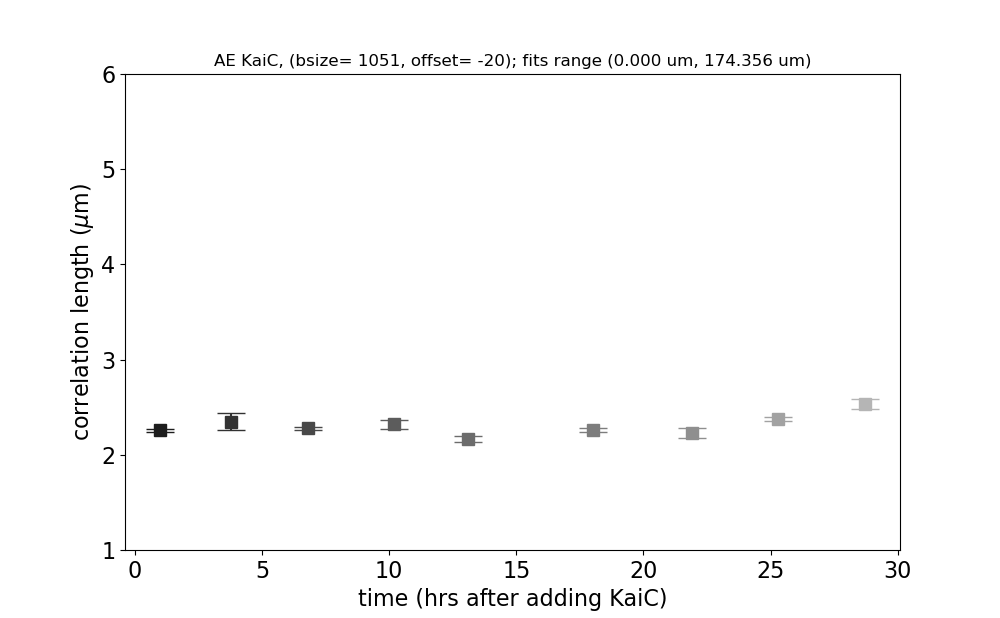

In [157]:
array_len = len(r1_params)
### set up empty arrays
all_cl = np.zeros((total_rows,array_len))
avg_cl = np.empty(array_len)
stderror_cl = np.empty(array_len)

### find average values and std. error for correlation lengths (lc) based on the fits 
for i in range(array_len):
    all_cl[0,i] = r1_params[i][1]
    all_cl[1,i] = r2_params[i][1]
    all_cl[2,i] = r3_params[i][1]
avg_cl = all_cl.mean(axis=0)
stderror_cl = (all_cl.std(axis=0))/np.sqrt(total_rows)   #
print(all_cl)
#print(all_cl.mean(axis=0))
#print(stderror_cl)

### plot average values and std. error for correlation lengths
fig, ax = plt.subplots(figsize=(fig_size))
markerSize = 8

for i in range(int(len(time_array))):
    plt.plot(time_array[i], avg_cl[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)))
    ax.errorbar(time_array[i], avg_cl[i], yerr = stderror_cl[i], fmt = 'none', 
                ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
    
plt.xlabel("Time (hrs after adding KaiC)",fontsize=font_size)
plt.ylabel("Correlation length ($\mu$m)",fontsize=font_size)
ax.tick_params(axis='both', which='major', labelsize=font_size)
plt.ylim(1,6)
#title_plus = title + "; n fits range (%5.3f um, %5.3f um)" %(all_xvalues[fit_start], x_fit_lim)
plt.title(title_plus, fontsize=font_size -4)
plt.show()

### save plot
fig.savefig(plot_saveto+exp+" threshold correlation lengths for "+title_plus+".jpg", dpi=dpi_num)

[[ 1.31979814e-03  1.63698855e-03 -3.97609906e-04  2.34933093e-04
   1.25406718e-04 -3.07808341e-04  6.00177153e-05 -2.49649253e-04
  -3.25343552e-04]
 [ 1.20396931e-03  1.19010037e-03  5.98056948e-04  5.99605799e-04
   1.36940429e-04 -2.65777503e-04 -1.16290834e-04 -5.03395778e-04
  -4.14411541e-04]
 [ 9.71680785e-04  1.15436274e-03  8.39786629e-04  1.15744500e-05
   5.23908761e-04  5.92518431e-04 -7.40590454e-05  6.84473530e-04
   2.50079341e-04]]


<IPython.core.display.Javascript object>


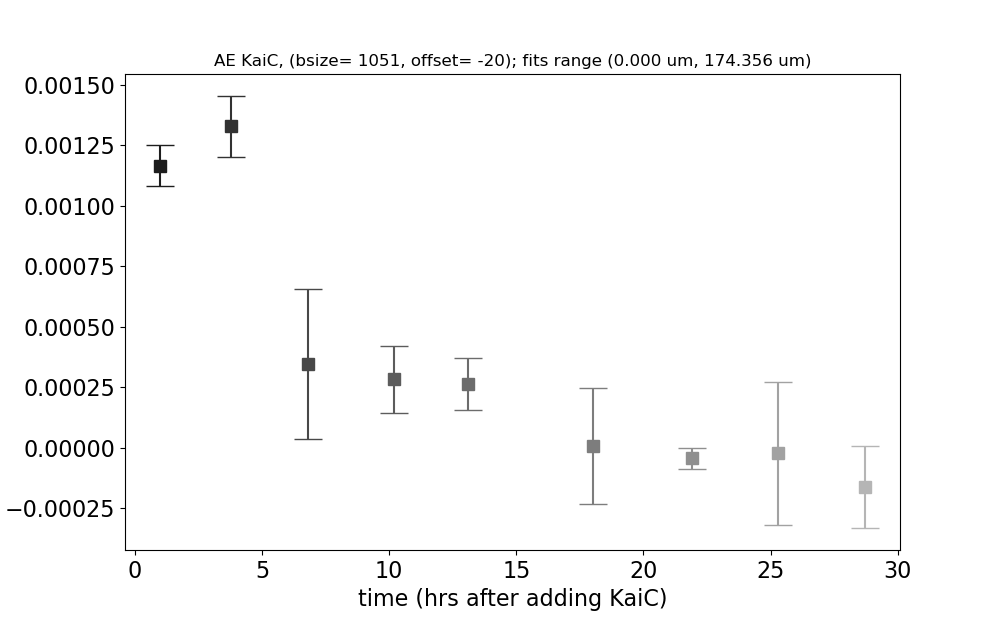

In [158]:
array_len = len(r1_params)
### set up empty arrays
all_A = np.zeros((total_rows,array_len))
avg_A = np.empty(array_len)
stderror_A = np.empty(array_len)

### find average values and std. error for correlation lengths (lc) based on the fits 
for i in range(array_len):
    all_A[0,i] = r1_params[i][0]
    all_A[1,i] = r2_params[i][0]
    all_A[2,i] = r3_params[i][0]
avg_A = all_A.mean(axis=0)
stderror_A = (all_A.std(axis=0))/np.sqrt(total_rows)   #
print(all_A)
#print(all_cl.mean(axis=0))
#print(stderror_cl)

### plot average values and std. error for correlation lengths
fig, ax = plt.subplots(figsize=(fig_size))
markerSize = 8

for i in range(int(len(time_array))):
    plt.plot(time_array[i], avg_A[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)))
    ax.errorbar(time_array[i], avg_A[i], yerr = stderror_A[i], fmt = 'none', 
                ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
    
plt.xlabel("time (hrs after adding KaiC)",fontsize=font_size)
plt.ylabel("offset parameter (... + A) value (unitless)",fontsize=font_size)
ax.tick_params(axis='both', which='major', labelsize=font_size)
#plt.ylim(0.001,0.04)
#title_plus = title + "; n fits range (%5.3f um, %5.3f um)" %(all_xvalues[fit_start], x_fit_lim)
plt.title(title_plus, fontsize=font_size -4)
plt.show()

### save plot
fig.savefig(plot_saveto+exp+" threshold A values for "+title_plus+".jpg", dpi=dpi_num)

## Save all results to 3 seperate CSV files --> use for plotting in origin later on 

In [159]:

### first CSV file: save fit parameters (coefficient 'A' and correlation length 'L1'), and avg autocorrelation plateau values
csv_data_file = exp+" results- threshold SIA fit parameters.csv"
data_file_exists = os.path.isfile(plot_saveto+csv_data_file)
if data_file_exists:
    print(csv_data_file + " already exists.")
    with open(plot_saveto+csv_data_file,'a', newline='') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow([title_plus])
        writer.writerow(['time (hrs)','','r1 A','r2 A','r3 A','','avg A', 'A std E','','','r1 cL','r2 cL','r3 cL','', 
                         'avg cL', 'cL std E'])
        for i in range(len(time_array)):
            writer.writerow([time_array[i],'', r1_params[i][0], r2_params[i][0], r3_params[i][0],'', avg_A[i], stderror_A[i],'','',
                             r1_params[i][1], r2_params[i][1], r3_params[i][1],'', avg_cl[i], stderror_cl[i]])
        writer.writerow([''])
    f.close()
    print("Results appended to "+ csv_data_file)
else:
    print(csv_data_file + " does NOT exist.")
    header = []
    np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
    with open(plot_saveto+csv_data_file,'a', newline='') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow([title_plus])
        writer.writerow(['time (hrs)','','r1 A','r2 A','r3 A','','avg A', 'A std E','','','r1 cL','r2 cL','r3 cL','', 
                         'avg cL', 'cL std E'])
        for i in range(len(time_array)):
            writer.writerow([time_array[i],'', r1_params[i][0], r2_params[i][0], r3_params[i][0],'', avg_A[i], stderror_A[i],'','',
                             r1_params[i][1], r2_params[i][1], r3_params[i][1],'', avg_cl[i], stderror_cl[i]])
        writer.writerow([''])
    f.close()
    print("New csv created, results appended to "+ csv_data_file)

### BOX PLOTS CSV file: save fit parameters (coefficient 'A' and correlation length 'L1'), and avg autocorrelation plateau values
csv_data_file = exp+" Box Plot results- threshold SIA fit parameters.csv"
data_file_exists = os.path.isfile(plot_saveto+csv_data_file)
if data_file_exists:
    print(csv_data_file + " already exists.")
    with open(plot_saveto+csv_data_file,'a', newline='') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow([title_plus])
        writer.writerow(['','A values','','','','','','','','','','','','correlation length'])
        writer.writerow(['time (hrs)',time_array[0],time_array[1],time_array[2],time_array[3],time_array[4],time_array[5],
                         time_array[6],time_array[7],time_array[8],'','',
                         'time (hrs)',time_array[0],time_array[1],time_array[2],time_array[3],time_array[4],time_array[5],
                         time_array[6],time_array[7],time_array[8],'','',])
        
        writer.writerow(['row1', r1_params[0][0], r1_params[1][0], r1_params[2][0], r1_params[3][0], r1_params[4][0],
                         r1_params[5][0], r1_params[6][0], r1_params[7][0], r1_params[8][0],'','',
                         'row1', r1_params[0][1], r1_params[1][1], r1_params[2][1], r1_params[3][1], r1_params[4][1],
                         r1_params[5][1], r1_params[6][1], r1_params[7][1], r1_params[8][1],'','',])
        
        writer.writerow(['row2', r2_params[0][0], r2_params[1][0], r2_params[2][0], r2_params[3][0], r2_params[4][0],
                         r2_params[5][0], r2_params[6][0], r2_params[7][0], r2_params[8][0],'','',
                         'row2', r2_params[0][1], r2_params[1][1], r2_params[2][1], r2_params[3][1], r2_params[4][1],
                         r2_params[5][1], r2_params[6][1], r2_params[7][1], r2_params[8][1],'','',])
        
        writer.writerow(['row3', r3_params[0][0], r3_params[1][0], r3_params[2][0], r3_params[3][0], r3_params[4][0],
                         r3_params[5][0], r3_params[6][0], r3_params[7][0], r3_params[8][0],'','',
                         'row3', r3_params[0][1], r3_params[1][1], r3_params[2][1], r3_params[3][1], r3_params[4][1],
                         r3_params[5][1], r3_params[6][1], r3_params[7][1], r3_params[8][1],'','',])
        writer.writerow([''])
        writer.writerow([''])
    f.close()
    print("Results appended to "+ csv_data_file)
else:
    print(csv_data_file + " does NOT exist.")
    header = []
    np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
    with open(plot_saveto+csv_data_file,'a', newline='') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow([title_plus])
        writer.writerow(['','A values','','','','','','','','','','','','correlation length'])
        writer.writerow(['time (hrs)',time_array[0],time_array[1],time_array[2],time_array[3],time_array[4],time_array[5],
                         time_array[6],time_array[7],time_array[8],'','',
                         'time (hrs)',time_array[0],time_array[1],time_array[2],time_array[3],time_array[4],time_array[5],
                         time_array[6],time_array[7],time_array[8],'','',])
        
        writer.writerow(['row1', r1_params[0][0], r1_params[1][0], r1_params[2][0], r1_params[3][0], r1_params[4][0],
                         r1_params[5][0], r1_params[6][0], r1_params[7][0], r1_params[8][0],'','',
                         'row1', r1_params[0][1], r1_params[1][1], r1_params[2][1], r1_params[3][1], r1_params[4][1],
                         r1_params[5][1], r1_params[6][1], r1_params[7][1], r1_params[8][1],'','',])
        
        writer.writerow(['row2', r2_params[0][0], r2_params[1][0], r2_params[2][0], r2_params[3][0], r2_params[4][0],
                         r2_params[5][0], r2_params[6][0], r2_params[7][0], r2_params[8][0],'','',
                         'row2', r2_params[0][1], r2_params[1][1], r2_params[2][1], r2_params[3][1], r2_params[4][1],
                         r2_params[5][1], r2_params[6][1], r2_params[7][1], r2_params[8][1],'','',])
        
        writer.writerow(['row3', r3_params[0][0], r3_params[1][0], r3_params[2][0], r3_params[3][0], r3_params[4][0],
                         r3_params[5][0], r3_params[6][0], r3_params[7][0], r3_params[8][0],'','',
                         'row3', r3_params[0][1], r3_params[1][1], r3_params[2][1], r3_params[3][1], r3_params[4][1],
                         r3_params[5][1], r3_params[6][1], r3_params[7][1], r3_params[8][1],'','',])
        writer.writerow([''])
        writer.writerow([''])
    f.close()
    print("New csv created, results appended to "+ csv_data_file)
    
### second CSV file: save raw data (x and y values) of each original SIA curve (3 curves for each time point)
csv_data_file = exp+" results- threshold SIA raw data"+title+".csv"   
header = []
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    for j in range(len(time_array)):
        time = str(time_array[j]) + ' hrs'
        writer.writerow([time])
        writer.writerow(['x vals','','r1 y vals','r2 y vals','r3 y vals','','avg y vals','avg y error'])
        for i in range(len(results_dict[time]['x vals'])):
            writer.writerow([results_dict[time]['x vals'][i],'', results_dict[time]['r1 y vals'][i],
                            results_dict[time]['r2 y vals'][i], results_dict[time]['r3 y vals'][i],'',
                            results_dict[time]['avg y vals'][i], results_dict[time]['avg y error'][i]])
        writer.writerow([''])
        writer.writerow([''])
f.close()

### third CSV file: save the raw data (x and y values) of each fit to each original SIA curve (3 curves for each time point)
csv_data_file = exp+" results- threshold SIA fits data"+title+".csv"
header = []
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    for j in range(len(time_array)):
        time = str(time_array[j]) + ' hrs'
        writer.writerow([time])
        writer.writerow(['x fit vals','','r1 fit vals','r2 fit vals','r3 fit vals'])
        for i in range(len(results_dict[time]['x fit vals'])):
            writer.writerow([results_dict[time]['x fit vals'][i], '', results_dict[time]['r1 fit vals'][i],
                            results_dict[time]['r2 fit vals'][i], results_dict[time]['r3 fit vals'][i]])
        writer.writerow([''])
        writer.writerow([''])
f.close()

results- threshold SIA fit parameters.csv already exists.
Results appended to results- threshold SIA fit parameters.csv
Box Plot results- threshold SIA fit parameters.csv already exists.
Results appended to Box Plot results- threshold SIA fit parameters.csv


## First round complete! 
## Now we can scroll back to the top and change the 'key' variable to run through the next frame (i.e. condition) of all tiff files